In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import platform

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# FutureWarning 제거
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.simplefilter(action='ignore', category=UserWarning) 

# Data pre-processing

In [2]:
steel_data = pd.read_csv('data/steel_data.csv')

steel_data = steel_data.drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)           # 'Unnamed: 0.1','Unnamed: 0' 칼럼제외
steel_data = steel_data[steel_data['ROLLING_TEMP_T5'] !=0]                   # ROLLING_TEMP_T5 값이 0 인 로우제외

In [3]:
 # 'FUR_NO','WORK_GR', 'SCALE','HSB' 칼럼 형변
steel_data['FUR_NO'] = steel_data['FUR_NO'].str.replace('호기','')          
steel_data['WORK_GR'] = steel_data['WORK_GR'].str.replace('조', '')
steel_data['WORK_GR'] = steel_data['WORK_GR'].astype('int64')

steel_data['SCALE']=steel_data['SCALE'].replace('양품',1).replace('불량',0)  
steel_data['HSB']=steel_data['HSB'].replace('적용',1).replace('미적용',0)

# ROLLING_DATE에서 이틀치 자료임을 확인하고 int형으로 바꿔주기 위해 48시간제를 적용하였음
steel_data['ROLLING_DATE']=pd.to_datetime(steel_data['ROLLING_DATE'])
steel_data['time']=(steel_data['ROLLING_DATE']).dt.strftime('%d %H')         
steel_data['day'] = steel_data['time'].apply(lambda x : int(x.split(' ')[0]))
steel_data['hour'] = steel_data['time'].apply(lambda x : int(x.split(' ')[1]))
steel_data['day'] = steel_data['day'].apply(lambda x : 24 if x==2 else 0)
steel_data['Time'] = steel_data['day'] + steel_data['hour']
steel_data.drop(labels=['time','day','hour'],axis=1,inplace=True)

steel_data['Line'] = steel_data.apply(lambda x : str(x['FUR_NO'])+'-'+str(x['FUR_NO_ROW']), axis=1)

# 부피 :'PT_VOl(m^3)', 밀도 : 'PT_DEN(ton/m^3)' 칼럼 추가
steel_data['PT_VOl(m^3)'] = steel_data.apply((lambda x: ((x['PT_THK'])*(x['PT_WDTH'])*(x['PT_LTH'])/(1000**3))), axis=1)    
steel_data['PT_DEN(ton/m^3)'] = steel_data.apply((lambda x: ((x['PT_WGT'])/(x['PT_VOl(m^3)'])/1000)), axis=1)
steel_data['PT_VOl(m^3)'] = steel_data['PT_VOl(m^3)'].apply(lambda x: round(x,2))
steel_data['PT_DEN(ton/m^3)'] = steel_data['PT_DEN(ton/m^3)'].apply(lambda x: round(x,2))

* SCALE 양품을 1로, 불량품 0으로 설정한 이유 : SCALE 칼럼을 mean 하면 양품률을 쉽게 구할수 있다.

In [4]:
# 살펴보니 FUR_SZ_TEMP = FUR_EXTEMP 같음. 코드를 통해 확인해보자 
print((steel_data["FUR_SZ_TEMP"] / steel_data["FUR_EXTEMP"]).min())
print((steel_data["FUR_SZ_TEMP"] / steel_data["FUR_EXTEMP"]).max())
# FUR_SZ_TEMP 칼럼과 FUR_EXTEMP 칼럼이 같은 값임을 확인. 하지만 살려놓겠음

1.0
1.0


In [5]:
""" l = []
for i in range(len(steel_data)):
    if steel_data.loc[i,"FUR_SZ_TEMP"] == steel_data.loc[i,"FUR_EXTEMP"]:
        l.append(0)
    else: l.append(1)
max(l) 
 """

' l = []\nfor i in range(len(steel_data)):\n    if steel_data.loc[i,"FUR_SZ_TEMP"] == steel_data.loc[i,"FUR_EXTEMP"]:\n        l.append(0)\n    else: l.append(1)\nmax(l) \n '

In [6]:

""" print('같다' if all(steel_data["FUR_SZ_TEMP"]) == all(steel_data["FUR_EXTEMP"]) else '다르다') """


' print(\'같다\' if all(steel_data["FUR_SZ_TEMP"]) == all(steel_data["FUR_EXTEMP"]) else \'다르다\') '

# Data processing

## HSB

Text(0.5, 1.0, '양품률(HSB공정 실시여부)')

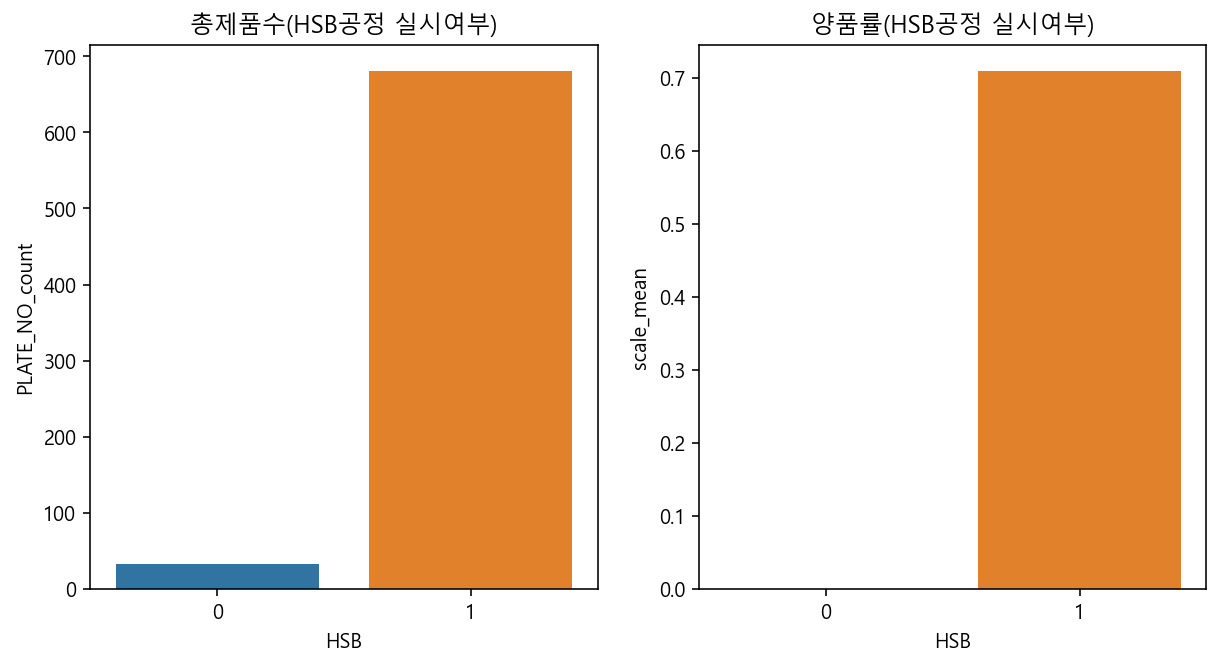

In [7]:
fig, ax = plt.subplots(ncols=2,figsize=(10,5))

sns.barplot(data = steel_data.groupby(['HSB'], as_index = False).agg(PLATE_NO_count = ('PLATE_NO', 'count')), x='HSB', y = 'PLATE_NO_count',ax=ax[0]).set_title('총제품수(HSB공정 실시여부)')
sns.barplot(data = steel_data.groupby(['HSB'], as_index = False).agg(scale_mean = ('SCALE', 'mean')), x='HSB', y = 'scale_mean',ax=ax[1]).set_title('양품률(HSB공정 실시여부)')

* HSB 공정이 미처리된 제품수와 처리된 제품수의 차이가 많이 나고, 미처리된 제품은 모두 불량임을 확인할수 있다.    -> on/off형  

## ROLLING_DESCALING

Text(0.5, 1.0, '양품률(ROLLING_DESCALING 별)')

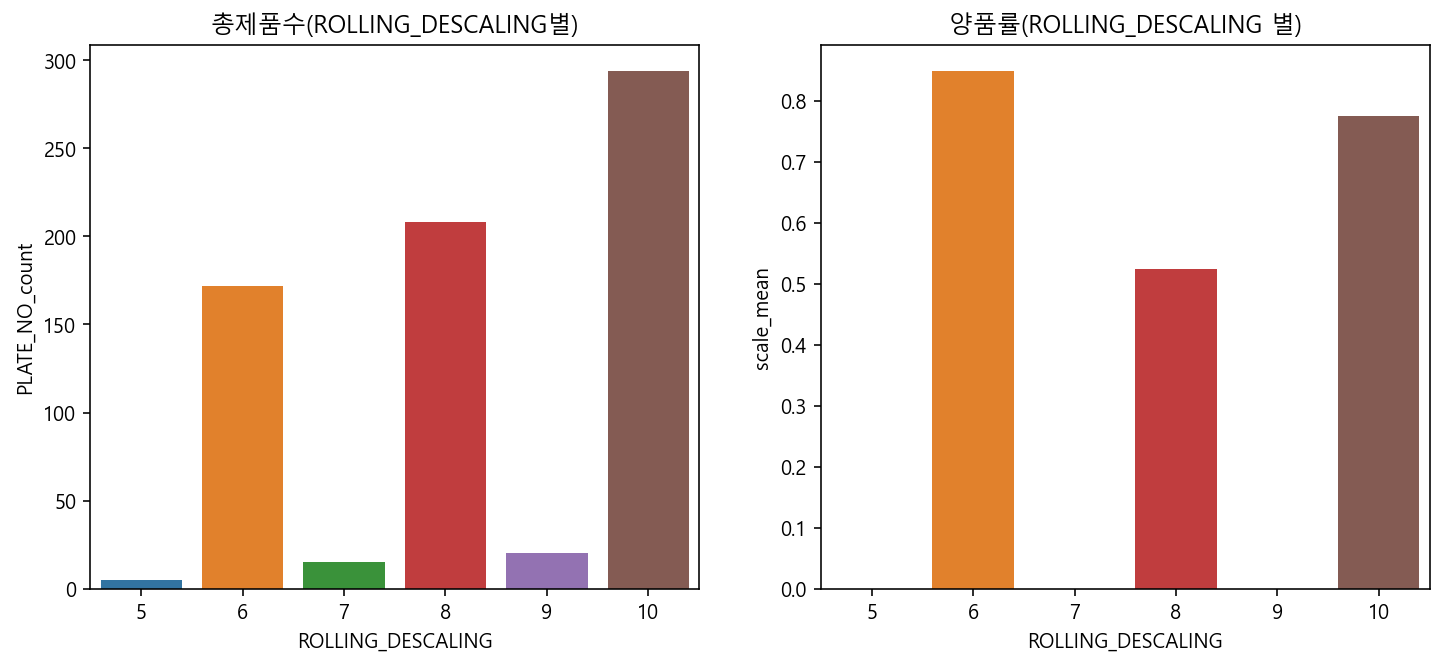

In [8]:
fig, ax = plt.subplots(ncols=2,figsize=(12,5))

sns.barplot(data = steel_data.groupby(['ROLLING_DESCALING',], as_index = False).agg(PLATE_NO_count = ('PLATE_NO', 'count')), x='ROLLING_DESCALING', y = 'PLATE_NO_count',ax=ax[0]).set_title('총제품수(ROLLING_DESCALING별)')
sns.barplot(data = steel_data.groupby(['ROLLING_DESCALING',], as_index = False).agg(scale_mean = ('SCALE', 'mean')), x='ROLLING_DESCALING', y = 'scale_mean',ax=ax[1]).set_title('양품률(ROLLING_DESCALING 별)')

* ROLLING_DESCALING 홀수번 처리된 제품수와 짝수번 처리된 제품수의 차이가 많이 나고, 홀수번 처리된 제품은 모두 불량임을 확인할수 있다. -> on/off형  
* ROLLING_DESCALING 공정은 고압수를 쏘아 scale을 제거하는 공정. 고정된 DESCALING 장치에 컨테이너벨트로 제품을 왕복시키는 방법이라 그 횟수가 홀수번이면 불량인듯 하다.

In [9]:
steel_data['RDnum']=steel_data.apply(lambda x : x['ROLLING_DESCALING']%2, axis=1)  # ROLLING_DESCALING의 홀/짝수 여부를 'RD_홀짝'칼럼으로 추가
steel_data['RDnum']=steel_data['RDnum'].apply(lambda x : 1 if x==0 else 0)       # SCALE , HSB 값과 RD_홀짝 값의 동기화를 위해 홀수를 0, 짝수를 1로 바꿈

## ROLLING_TEMP_T5

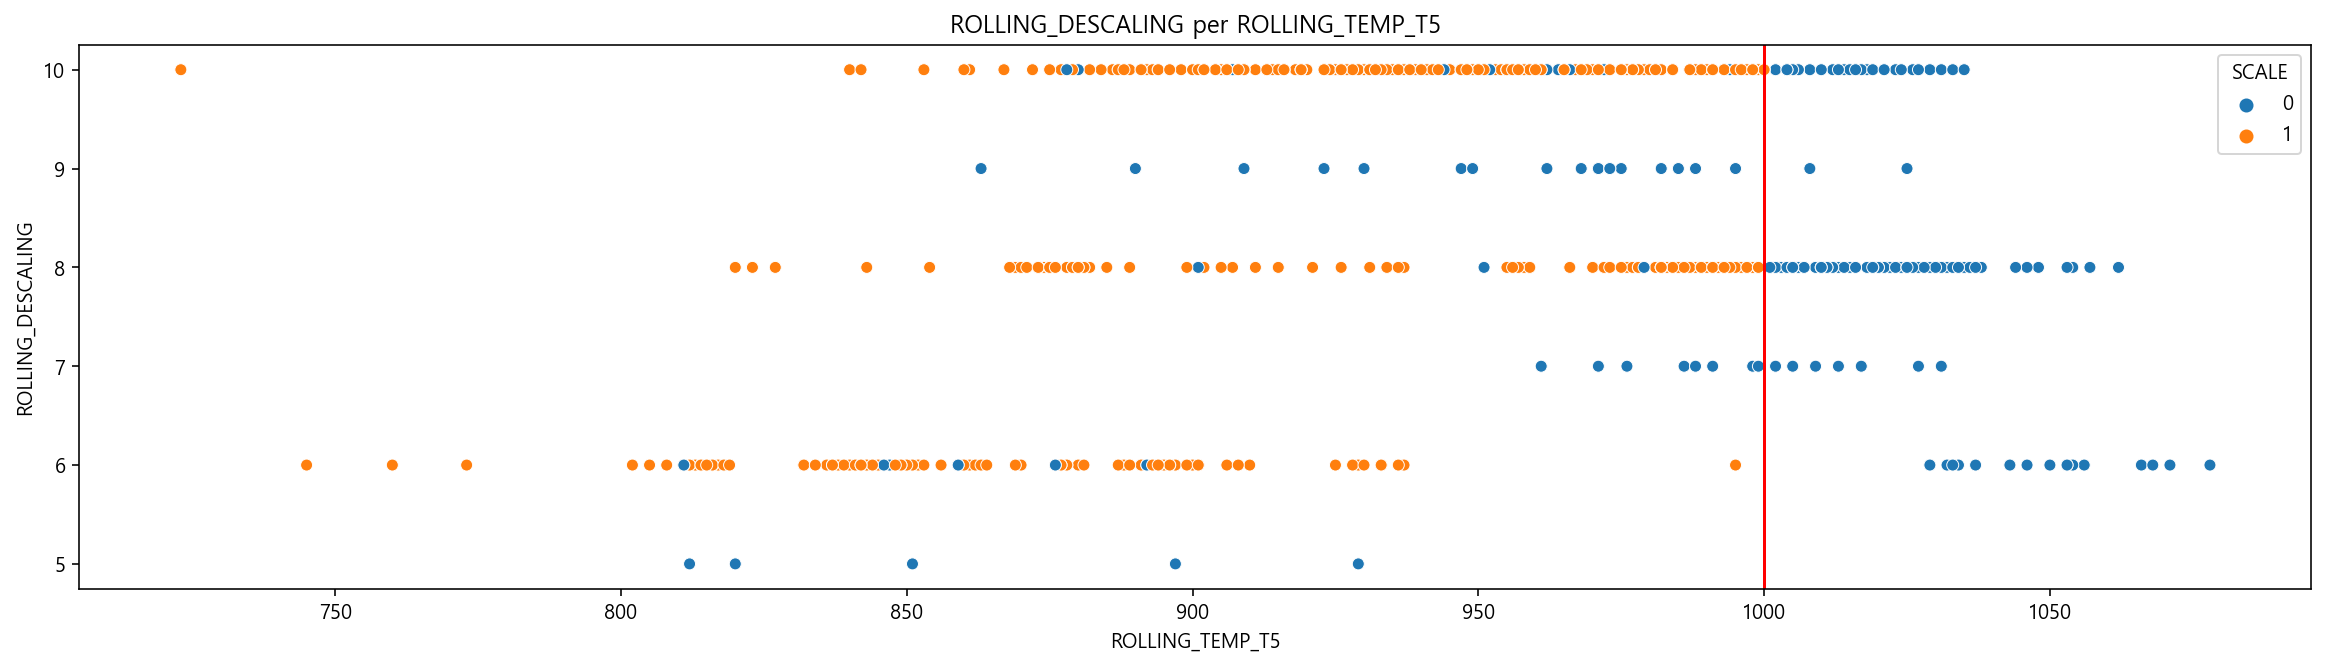

In [10]:
i=1
fig, ax = plt.subplots(nrows=i,figsize=(20,5*i))
sns.scatterplot(data=steel_data, x ='ROLLING_TEMP_T5', y = 'ROLLING_DESCALING', hue='SCALE',ax=ax).set_title('ROLLING_DESCALING per ROLLING_TEMP_T5')
plt.axvline(1000, color='r')
plt.show()

* ROLLING_DESCALING과 ROLLING_TEMP_T5는 독립적이라 볼수있다. 다만 6회일떄는 다소 그 온도가 낮다.
* ROLLING_TEMP_T5가 1000도를 초과하면 불량품이 된다.   -> on/off형    
* 총 714개 중 79.7%인 152개가 그에 해당한다.  총양품률 67%과 비교하면 ROLLING_TEMP_T5칼럼의 importance가 큼을 알수 있다. 

In [11]:
steel_data['RT1000']=steel_data.apply(lambda x : x['ROLLING_TEMP_T5']//1001, axis=1)  # ROLLING_TEMP_T5의 1000도 초과 여부를 'RT1000'칼럼으로 추가
steel_data['RT1000']=steel_data['RT1000'].apply(lambda x : 0 if x==1 else 1)          # SCALE , HSB 값과 RD_홀짝 값의 동기화를 위해 1000도 이하를 1, 초과를 0로 바꿈

In [12]:
steel_extr_SZ1175 = steel_data[steel_data['HSB']==1][steel_data['RDnum']==1][steel_data['RT1000']==1]  # on/off형인 HSB , RDnum , RT1000 칼럼을 이용해 압연공정 정상 데이터만을 추출 

## 가열로 공정

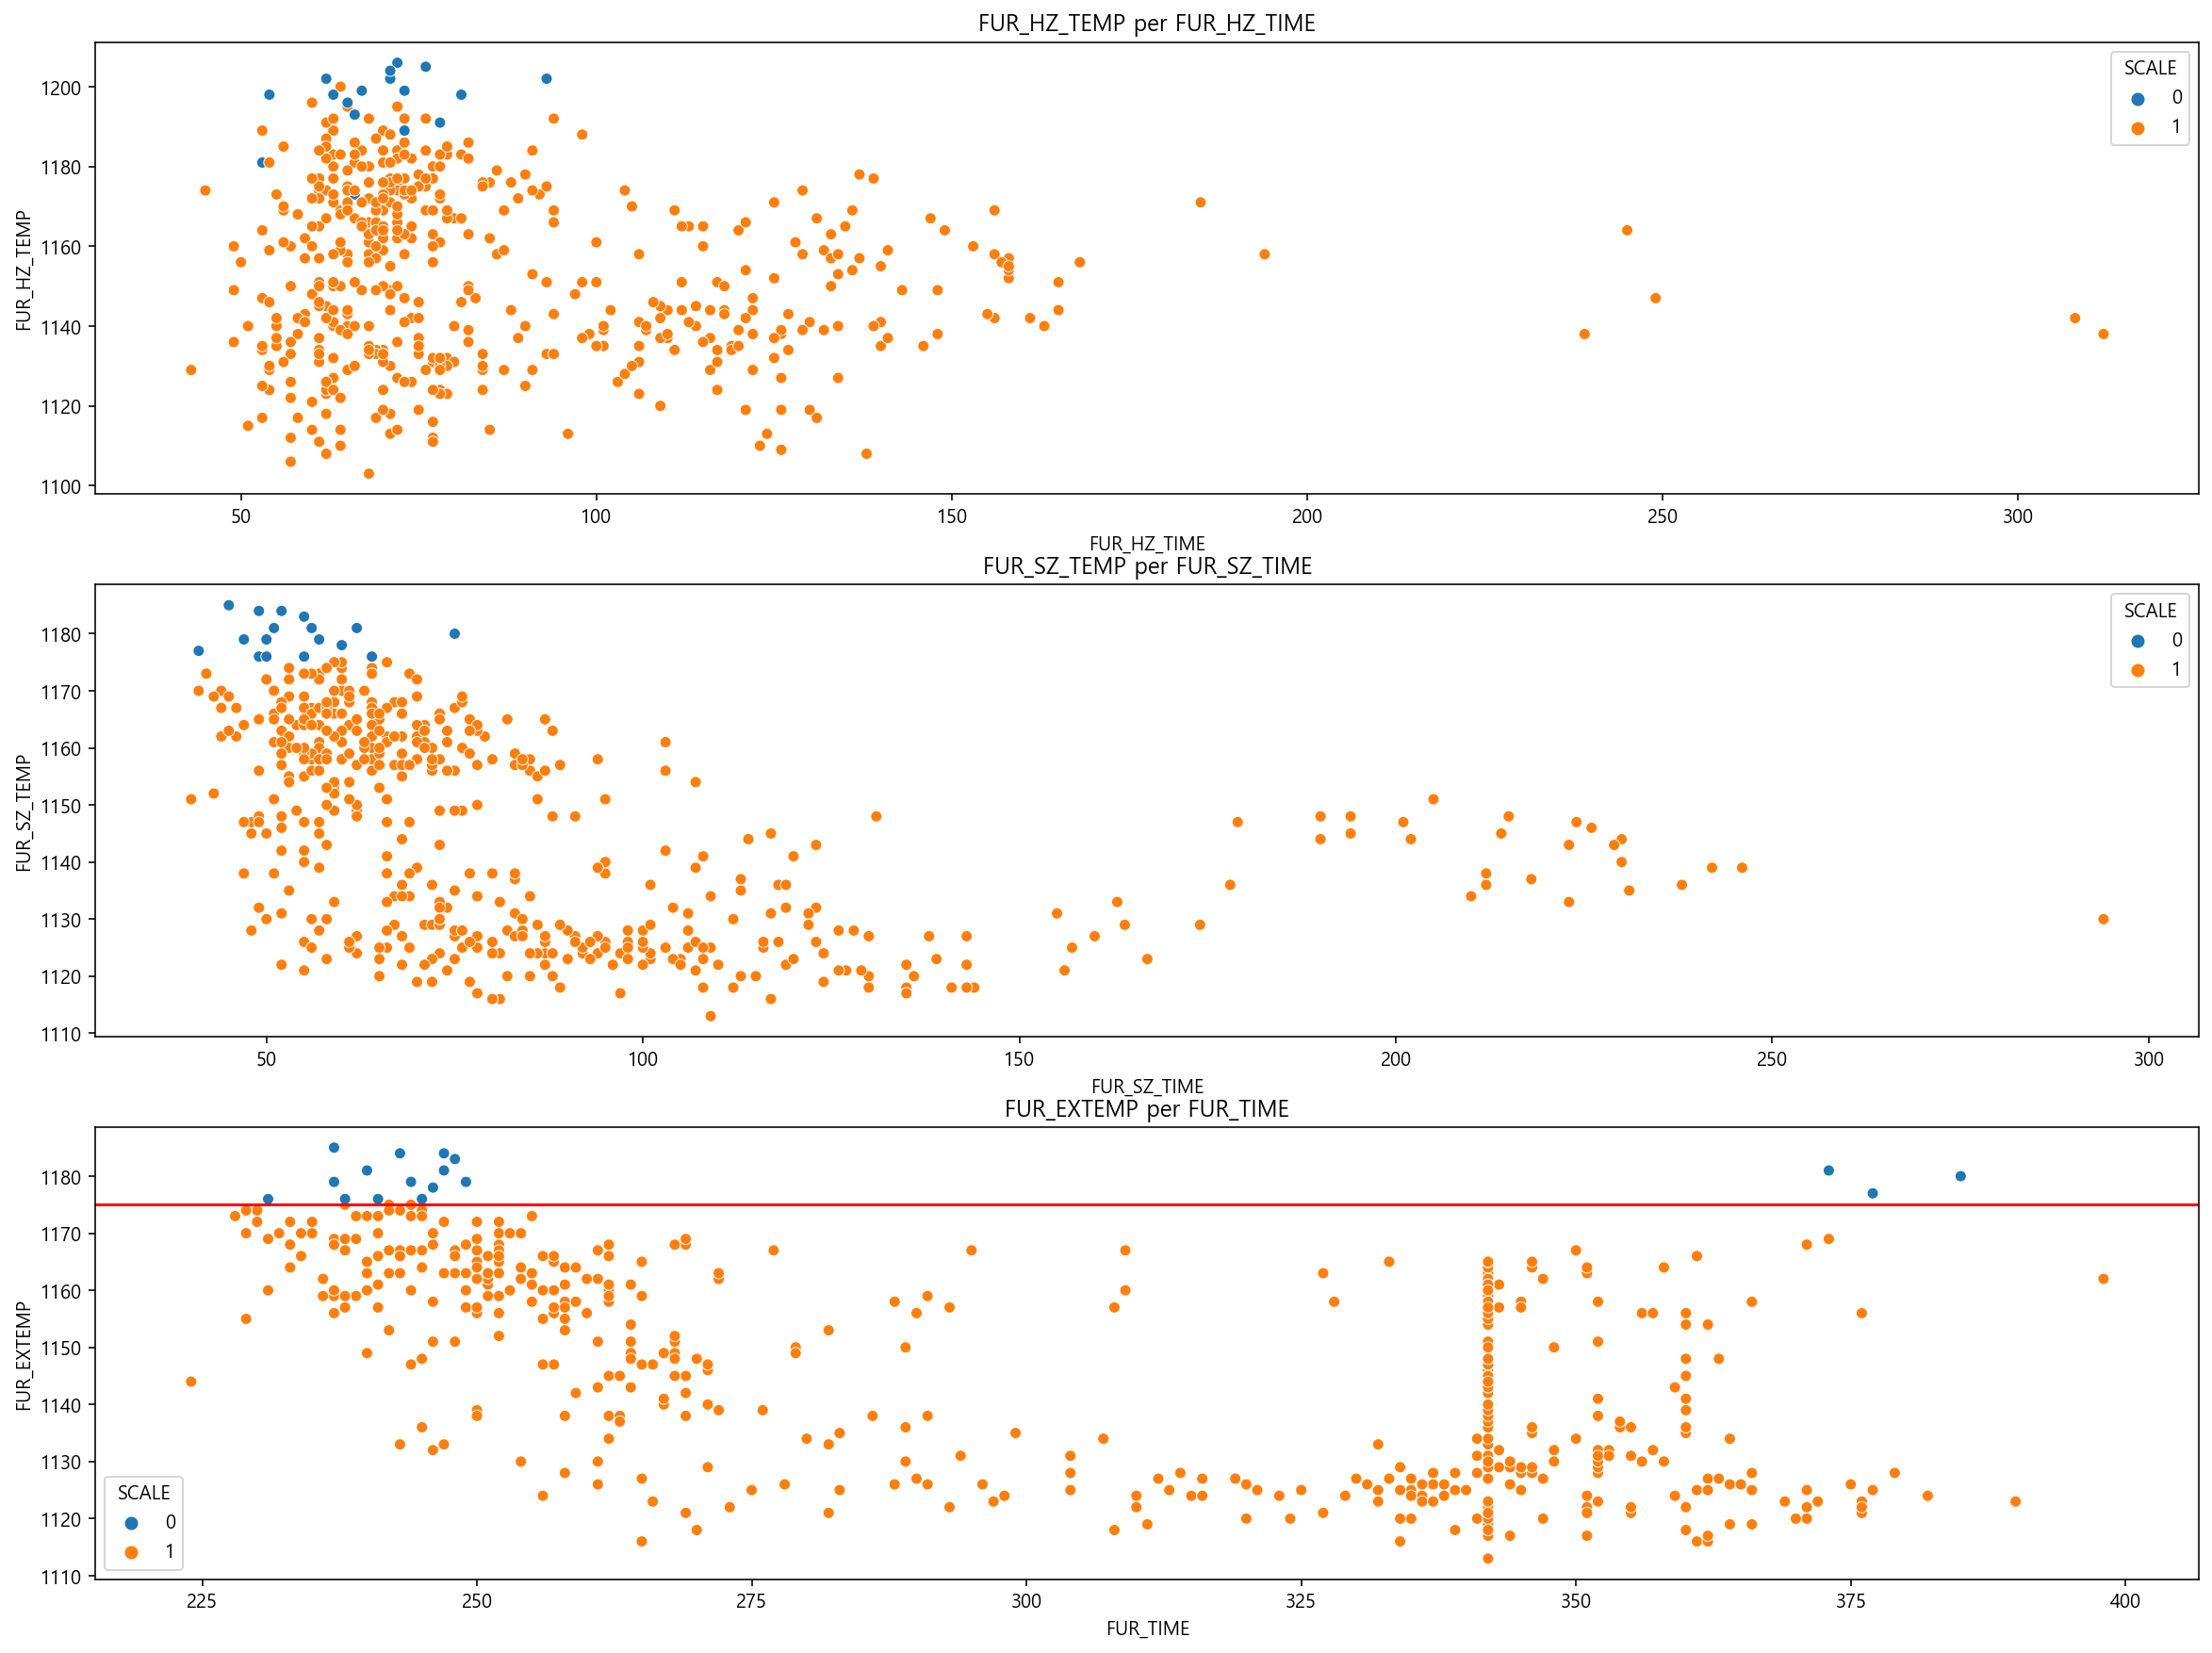

In [13]:
fig, ax = plt.subplots(nrows=3,figsize=(20,15))

sns.scatterplot(data=steel_extr_SZ1175, x ='FUR_HZ_TIME', y = 'FUR_HZ_TEMP', hue='SCALE',ax=ax[0]).set_title('FUR_HZ_TEMP per FUR_HZ_TIME')
plt.axhline(1175, color='r')
sns.scatterplot(data=steel_extr_SZ1175, x ='FUR_SZ_TIME', y = 'FUR_SZ_TEMP', hue='SCALE',ax=ax[1]).set_title('FUR_SZ_TEMP per FUR_SZ_TIME')
plt.axhline(1175, color='r')
sns.scatterplot(data=steel_extr_SZ1175, x ='FUR_TIME', y = 'FUR_EXTEMP', hue='SCALE',ax=ax[2]).set_title('FUR_EXTEMP per FUR_TIME')
plt.axhline(1175, color='r')
plt.show()

* 세가지 세부 가열공정의 온도와 시간 중 불량율과는 세 세부 가열공정 모두 공정온도만 관련있다고 강하게 생각됨. 6분이상인 데이터가 있는 3번공정은 특히 더.
* 2번 그래프을 보고, 원 데이터를 확인해보니 FUR_SZ_TEMP 온도가(위에서 확인해보았듯 FUR_EXTEMP와 같은값을 가짐) 1175도 초과하면 ROLLING_TEMP_T5, HSB, ROLLING_DESCALING 와 관련 없이 죄다 불량         -> 마지막 on/off 스위치 

In [14]:
steel_data['SZ1175']=steel_data.apply(lambda x : x['FUR_SZ_TEMP']//1176, axis=1)  # ROLLING_TEMP_T5의 1000도 초과 여부를 'RT1000'칼럼으로 추가
steel_data['SZ1175']=steel_data['SZ1175'].apply(lambda x : 0 if x==1 else 1)      # SCALE , HSB 값과 RD_홀짝 값의 동기화를 위해 1000도 이하를 1, 초과를 0로 바꿈

## Data processing Result

* ROLLING_TEMP_T5 > 1000 [152개]  or HSB 안함[33개] or ROLLING_DESCALING = 홀수 [40개] or FUR_SZ_TEMP > 1175 [23개] 이면 불량! [총 714개 중 231개 불량]
* 이 4개의 요소들이 on/off 스위치임을 확인해보자.

In [15]:
steel_data.describe()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,...,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,Time,PT_VOl(m^3),PT_DEN(ton/m^3),RDnum,RT1000,SZ1175
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,...,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.676471,29.108091,2809.885154,34404.029412,41506.078431,1.497199,1155.459384,88.563025,1149.774510,78.899160,...,941.768908,0.953782,8.327731,2.514006,18.341737,2.129090,19.427101,0.943978,0.787115,0.967787
std,0.468151,18.994878,516.293303,13799.227159,24799.277300,0.500343,20.844557,37.780529,17.508271,36.551271,...,65.810993,0.210105,1.618317,1.148424,11.232255,0.384483,11.031469,0.230126,0.409634,0.176689
min,0.000000,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,35.000000,...,723.000000,0.000000,5.000000,1.000000,0.000000,1.000000,7.850000,0.000000,0.000000,0.000000
25%,0.000000,16.090000,2469.000000,22664.500000,17780.000000,1.000000,1139.000000,65.000000,1133.000000,57.000000,...,891.000000,1.000000,7.000000,1.000000,9.000000,1.820000,7.850000,1.000000,1.000000,1.000000
50%,1.000000,20.130000,2727.500000,37380.000000,36090.000000,1.000000,1158.000000,74.500000,1155.000000,68.000000,...,952.000000,1.000000,8.000000,3.000000,16.000000,2.080000,15.700000,1.000000,1.000000,1.000000
75%,1.000000,38.430000,3125.000000,43771.750000,61120.000000,2.000000,1171.000000,101.000000,1164.000000,86.000000,...,995.000000,1.000000,10.000000,4.000000,30.000000,2.400000,23.550000,1.000000,1.000000,1.000000
max,1.000000,100.340000,4575.000000,54917.000000,115080.000000,2.000000,1206.000000,312.000000,1185.000000,294.000000,...,1078.000000,1.000000,10.000000,4.000000,38.000000,2.980000,47.100000,1.000000,1.000000,1.000000


In [16]:
# 원본데이터를 이용 가설이 맞는지 확인해보자
steel_extr = steel_data[steel_data['SZ1175']==1][steel_data['HSB']==1][steel_data['RT1000']==1][steel_data['RDnum']==1]  # (ROLLING_TEMP_T5 > 1000  or HSB 안함 or ROLLING_DESCALING = 홀수  or FUR_SZ_TEMP > 1175) 의 대우   
steel_extr.describe()                                                                                                                

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,...,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,Time,PT_VOl(m^3),PT_DEN(ton/m^3),RDnum,RT1000,SZ1175
count,483.0,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,...,483.000000,483.0,483.000000,483.000000,483.000000,483.000000,483.000000,483.0,483.0,483.0
mean,1.0,30.694549,2885.389234,33476.511387,37752.919255,1.505176,1151.923395,87.109731,1145.246377,85.026915,...,916.648033,1.0,8.339545,2.517598,18.697723,2.124306,17.569048,1.0,1.0,1.0
std,0.0,20.654654,505.356262,15216.560876,24102.487595,0.500492,21.072399,34.261115,17.715577,40.965339,...,56.719265,0.0,1.728642,1.132874,11.534709,0.379900,10.580440,0.0,0.0,0.0
min,1.0,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,40.000000,...,723.000000,1.0,6.000000,1.000000,0.000000,1.000000,7.850000,1.0,1.0,1.0
25%,1.0,15.080000,2512.500000,17112.500000,15690.000000,1.000000,1135.000000,64.500000,1127.500000,59.000000,...,875.000000,1.0,6.000000,1.500000,10.000000,1.820000,7.850000,1.0,1.0,1.0
50%,1.0,20.130000,2880.000000,37198.000000,32420.000000,2.000000,1151.000000,73.000000,1147.000000,71.000000,...,926.000000,1.0,8.000000,3.000000,18.000000,2.050000,15.700000,1.0,1.0,1.0
75%,1.0,40.350000,3166.000000,47657.000000,51680.000000,2.000000,1169.000000,106.000000,1161.500000,95.000000,...,965.000000,1.0,10.000000,4.000000,30.000000,2.380000,23.550000,1.0,1.0,1.0
max,1.0,89.630000,4575.000000,54917.000000,115080.000000,2.000000,1200.000000,312.000000,1175.000000,294.000000,...,1000.000000,1.0,10.000000,4.000000,38.000000,2.980000,47.100000,1.0,1.0,1.0


* 원본데이터의 양품 개수 : 714-231 = 483 과 추출된 데이터의 SCALE count가 483으로 동일함을 확인
* 양품률인 추출된 데이터의 SCALE mean이 1.0 임을 확인. 가설 성립!

### Result visualising

In [17]:
a = len(steel_data)
b = len(steel_data[steel_data['SZ1175']==0])
c = len(steel_data[steel_data['SZ1175']==1][steel_data['HSB']==0])
d = len(steel_data[steel_data['SZ1175']==1][steel_data['HSB']==1][steel_data['RDnum']==0])
e = len(steel_data[steel_data['SZ1175']==1][steel_data['HSB']==1][steel_data['RDnum']==1][steel_data['RT1000']==0]) 

In [18]:
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

input = '[Total]=714'
node1_f = '[FUR_SZ_TEMP fail]=23'
node1_s = '[FUR_SZ_TEMP pass]=691'
node2_f = '[HSB fail]=32'
node2_s = '[HSB pass]=659'
node3_f = '[ROLLING_DESCALING fail]=36'
node3_s = '[ROLLING_DESCALING pass]=623'
node4_f = '[ROLLING_TEMP_T5 fail]=140'
output = '[ROLLING_TEMP_T5 pass]=483'

node_label = [ input
              , node1_f, node1_s
              , node2_f, node2_s
              , node3_f, node3_s
              , node4_f
              , output ]
node_dict = {y:x for x, y in enumerate(node_label)}
node_dict

source = [  input  , input   , node1_s, node1_s , node2_s, node2_s , node3_s, node3_s ]
target = [  node1_f, node1_s , node2_f, node2_s , node3_f, node3_s , node4_f, output ] 
values = [ b, a-b, c, a-b-c, d, a-b-c-d, e, a-b-c-d-e]

source_node = [node_dict[x] for x in source]
target_node = [node_dict[x] for x in target]

import plotly.graph_objects as go # Import the graphical object

fig = go.Figure( 
    data=[go.Sankey( # The plot we are interest
        # This part is for the node information
        node = dict( 
            label = node_label
        ),
        # This part is for the link information
        link = dict(
            source = source_node,
            target = target_node,
            value = values
        ))])

# With this save the plots 
plot(fig,
     image_filename='sankey_plot_labeled', 
     image='png', 
     image_width=1000, 
     image_height=600
) 
# And shows the plot
fig.show()

In [19]:
""" 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
# basic sankey chart

Sankey(flows=[a/a, -b/a, -c/a, -d/a, -e/a, -(a-b-c-d-e)/a], labels=[ '총물품', 'SZ1175>1175', 'HSB불량', 'RDnum=홀수', 'RT1000>1000' ,'총양품'], orientations=[ 0, 1, 1, 1, 1, 0]).finish()
plt.title("Sankey diagram with default settings")
plt.show() 
 """

' \nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom matplotlib.sankey import Sankey\n# basic sankey chart\n\nSankey(flows=[a/a, -b/a, -c/a, -d/a, -e/a, -(a-b-c-d-e)/a], labels=[ \'총물품\', \'SZ1175>1175\', \'HSB불량\', \'RDnum=홀수\', \'RT1000>1000\' ,\'총양품\'], orientations=[ 0, 1, 1, 1, 1, 0]).finish()\nplt.title("Sankey diagram with default settings")\nplt.show() \n '

### Data extract
* SZ1175, HSB, RDnum, RT1000 네 요소들 각각과 나머지 칼럼들의 관계를 알아보기 위해 네 요소 중 한개 칼럼을 기준으로 나머지 셋의 영향력을 제거한 데이터셋을 만들었다. 
* ~~스위치 off 가 2개인 데이터들까지 포함하였다.~~ 스위치 off 가 3개이상인 데이터는 없다.
* 스위치가 한개만 off여도 불량이 되고, 공정 flow가 연속적이므로 스위치가 두개 이상 off인 데이터를 굳이 구분할 필요가 없다. 그 수도 17개로 총불량품 231개의 10% 미만에 불과하다.  

In [20]:
# SZ1175 관련
steel_extr_SZ1175 = steel_data[steel_data['HSB']==1][steel_data['RDnum']==1][steel_data['RT1000']==1] 
""" steel_extr_SZ1175 = pd.concat([steel_data[steel_data['HSB']==1][steel_data['RDnum']==1][steel_data['RT1000']==1]                                   
    ,steel_data[steel_data['SZ1175']==0][steel_data['HSB']==0]
        ,steel_data[steel_data['SZ1175']==0][steel_data['RDnum']==0]
            ,steel_data[steel_data['SZ1175']==0][steel_data['RT1000']==0]]) """                                             
# HSB 관련
steel_extr_HSB = steel_data[steel_data['SZ1175']==1][steel_data['RDnum']==1][steel_data['RT1000']==1]
""" steel_extr_HSB = pd.concat([steel_data[steel_data['SZ1175']==1][steel_data['RDnum']==1][steel_data['RT1000']==1]
    ,steel_data[steel_data['HSB']==0][steel_data['SZ1175']==0]
        ,steel_data[steel_data['HSB']==0][steel_data['RDnum']==0]
            ,steel_data[steel_data['HSB']==0][steel_data['RT1000']==0]])  """                                                
# RDnum 관련
steel_extr_RDnum = steel_data[steel_data['HSB']==1][steel_data['SZ1175']==1][steel_data['RT1000']==1]           
""" steel_extr_RDnum = pd.concat([steel_data[steel_data['HSB']==1][steel_data['SZ1175']==1][steel_data['RT1000']==1]
    ,steel_data[steel_data['RDnum']==0][steel_data['HSB']==0]
        ,steel_data[steel_data['RDnum']==0][steel_data['SZ1175']==0]
            ,steel_data[steel_data['RDnum']==0][steel_data['RT1000']==0]]) """                                               
# RT1000 관련
steel_extr_RT1000 = steel_data[steel_data['HSB']==1][steel_data['SZ1175']==1][steel_data['RDnum']==1]            
""" steel_extr_RT1000 = pd.concat([steel_data[steel_data['HSB']==1][steel_data['SZ1175']==1][steel_data['RDnum']==1]
    ,steel_data[steel_data['RT1000']==0][steel_data['HSB']==0]
        ,steel_data[steel_data['RT1000']==0][steel_data['SZ1175']==0]
            ,steel_data[steel_data['RT1000']==0][steel_data['RDnum']==0]]) """                                               

" steel_extr_RT1000 = pd.concat([steel_data[steel_data['HSB']==1][steel_data['SZ1175']==1][steel_data['RDnum']==1]\n    ,steel_data[steel_data['RT1000']==0][steel_data['HSB']==0]\n        ,steel_data[steel_data['RT1000']==0][steel_data['SZ1175']==0]\n            ,steel_data[steel_data['RT1000']==0][steel_data['RDnum']==0]]) "

# Data Visualising & Analysis

## per Time

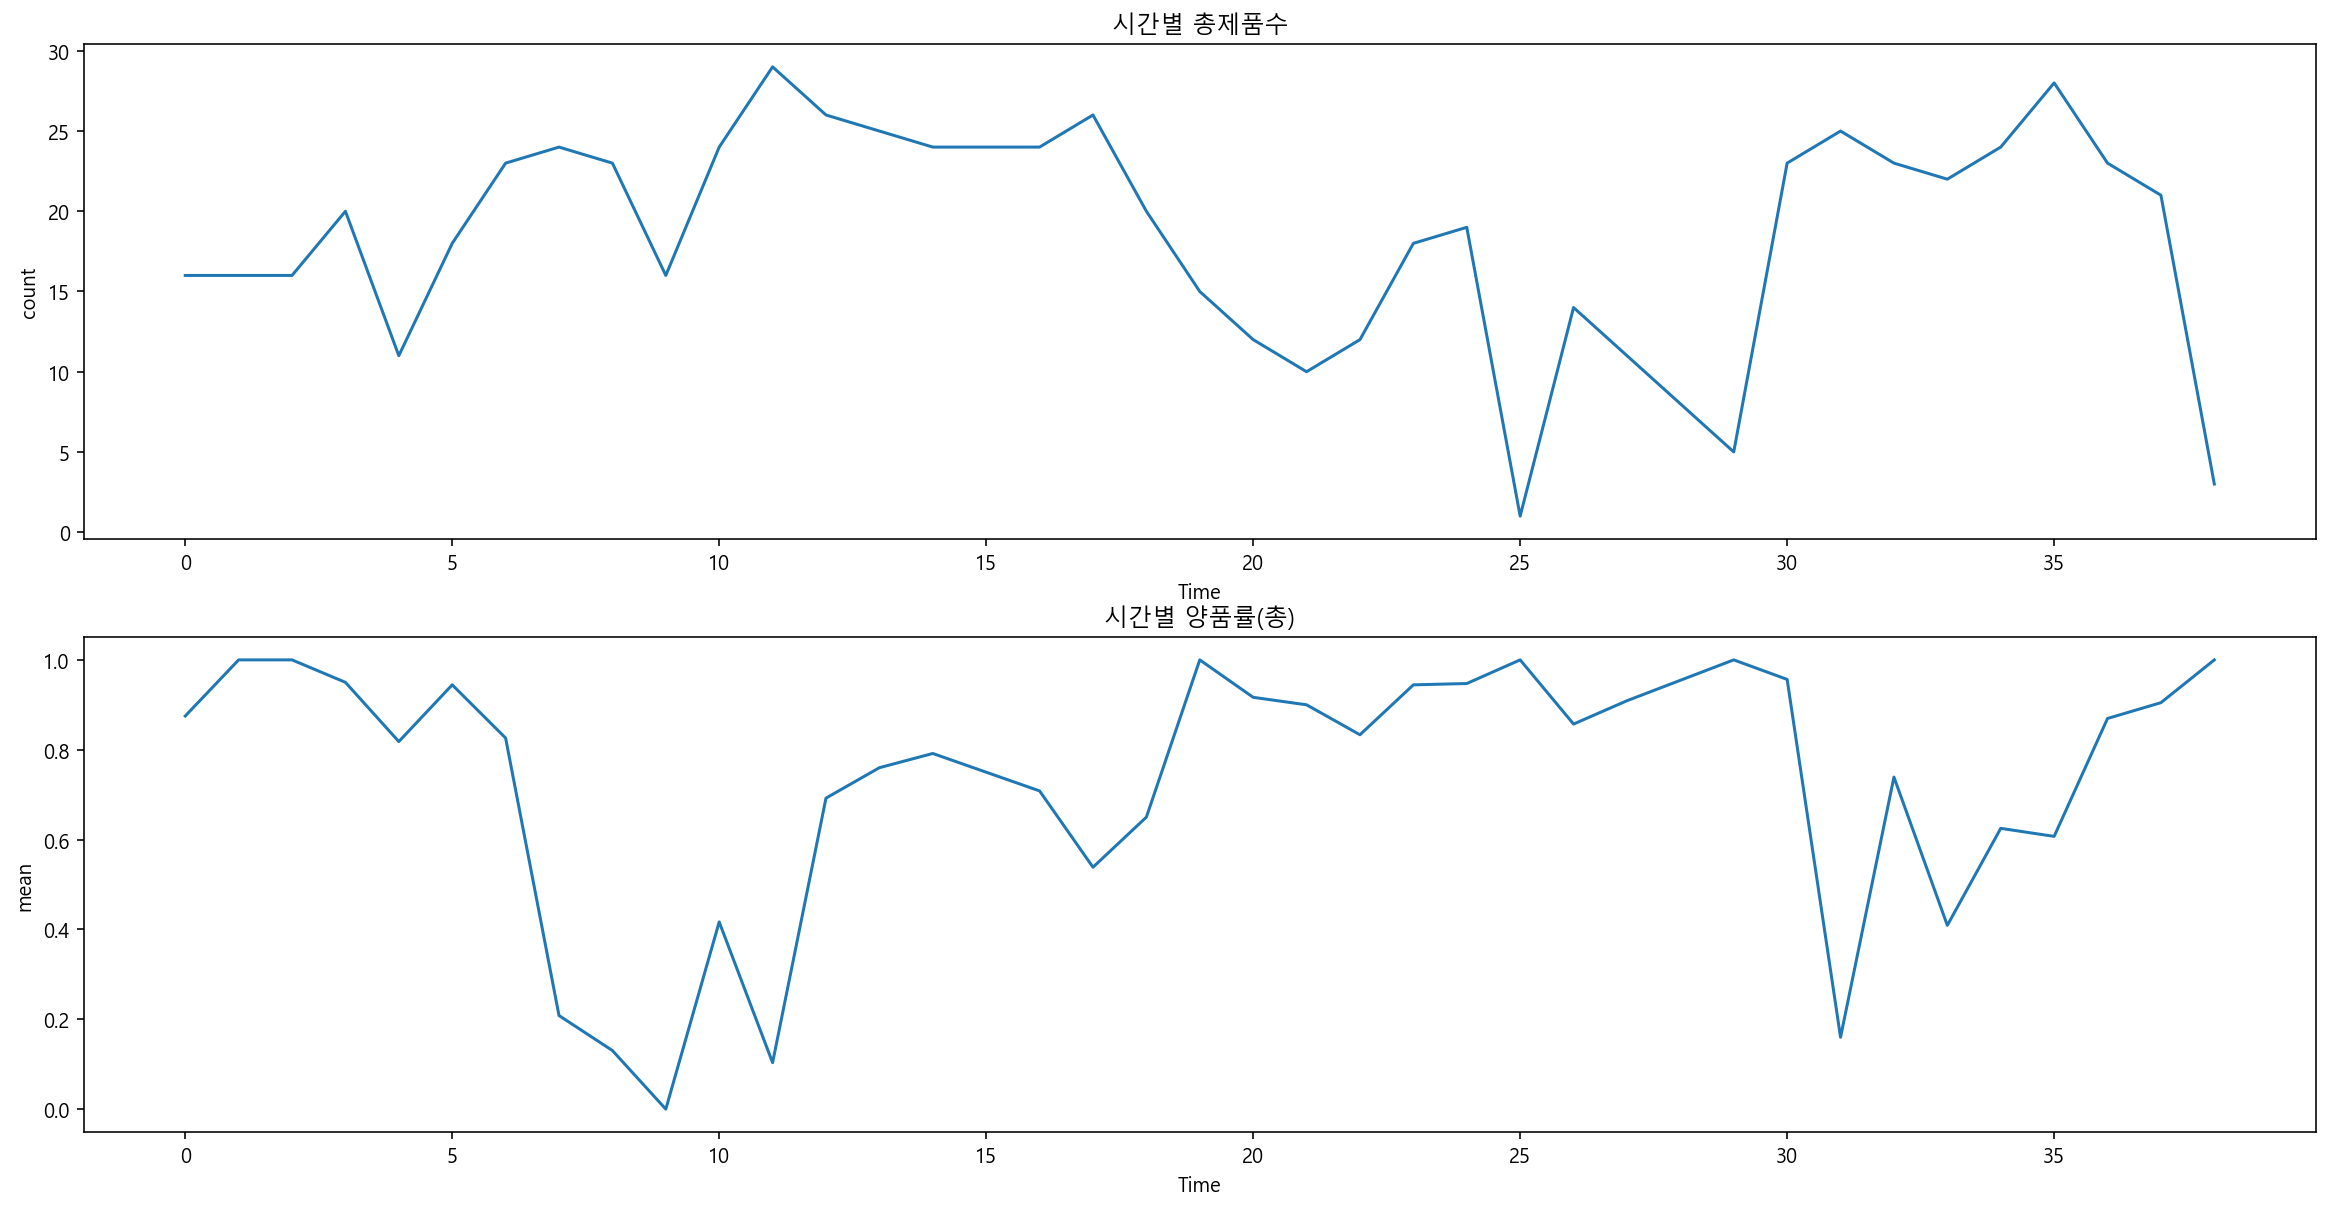

In [21]:
i=2
fig, ax = plt.subplots(nrows=i,figsize=(20,5*i))

sns.lineplot(data=steel_data.groupby('Time', as_index = False).agg(count = ('PLATE_NO', 'count')), x ='Time', y = 'count',ax=ax[0]).set_title('시간별 총제품수')
sns.lineplot(data=steel_data.groupby('Time', as_index = False).agg(mean = ('SCALE', 'mean')), x ='Time', y = 'mean',ax=ax[1]).set_title('시간별 양품률(총)')

plt.show()

### FUR_SZ_TEMP 관련 양품률 per Time

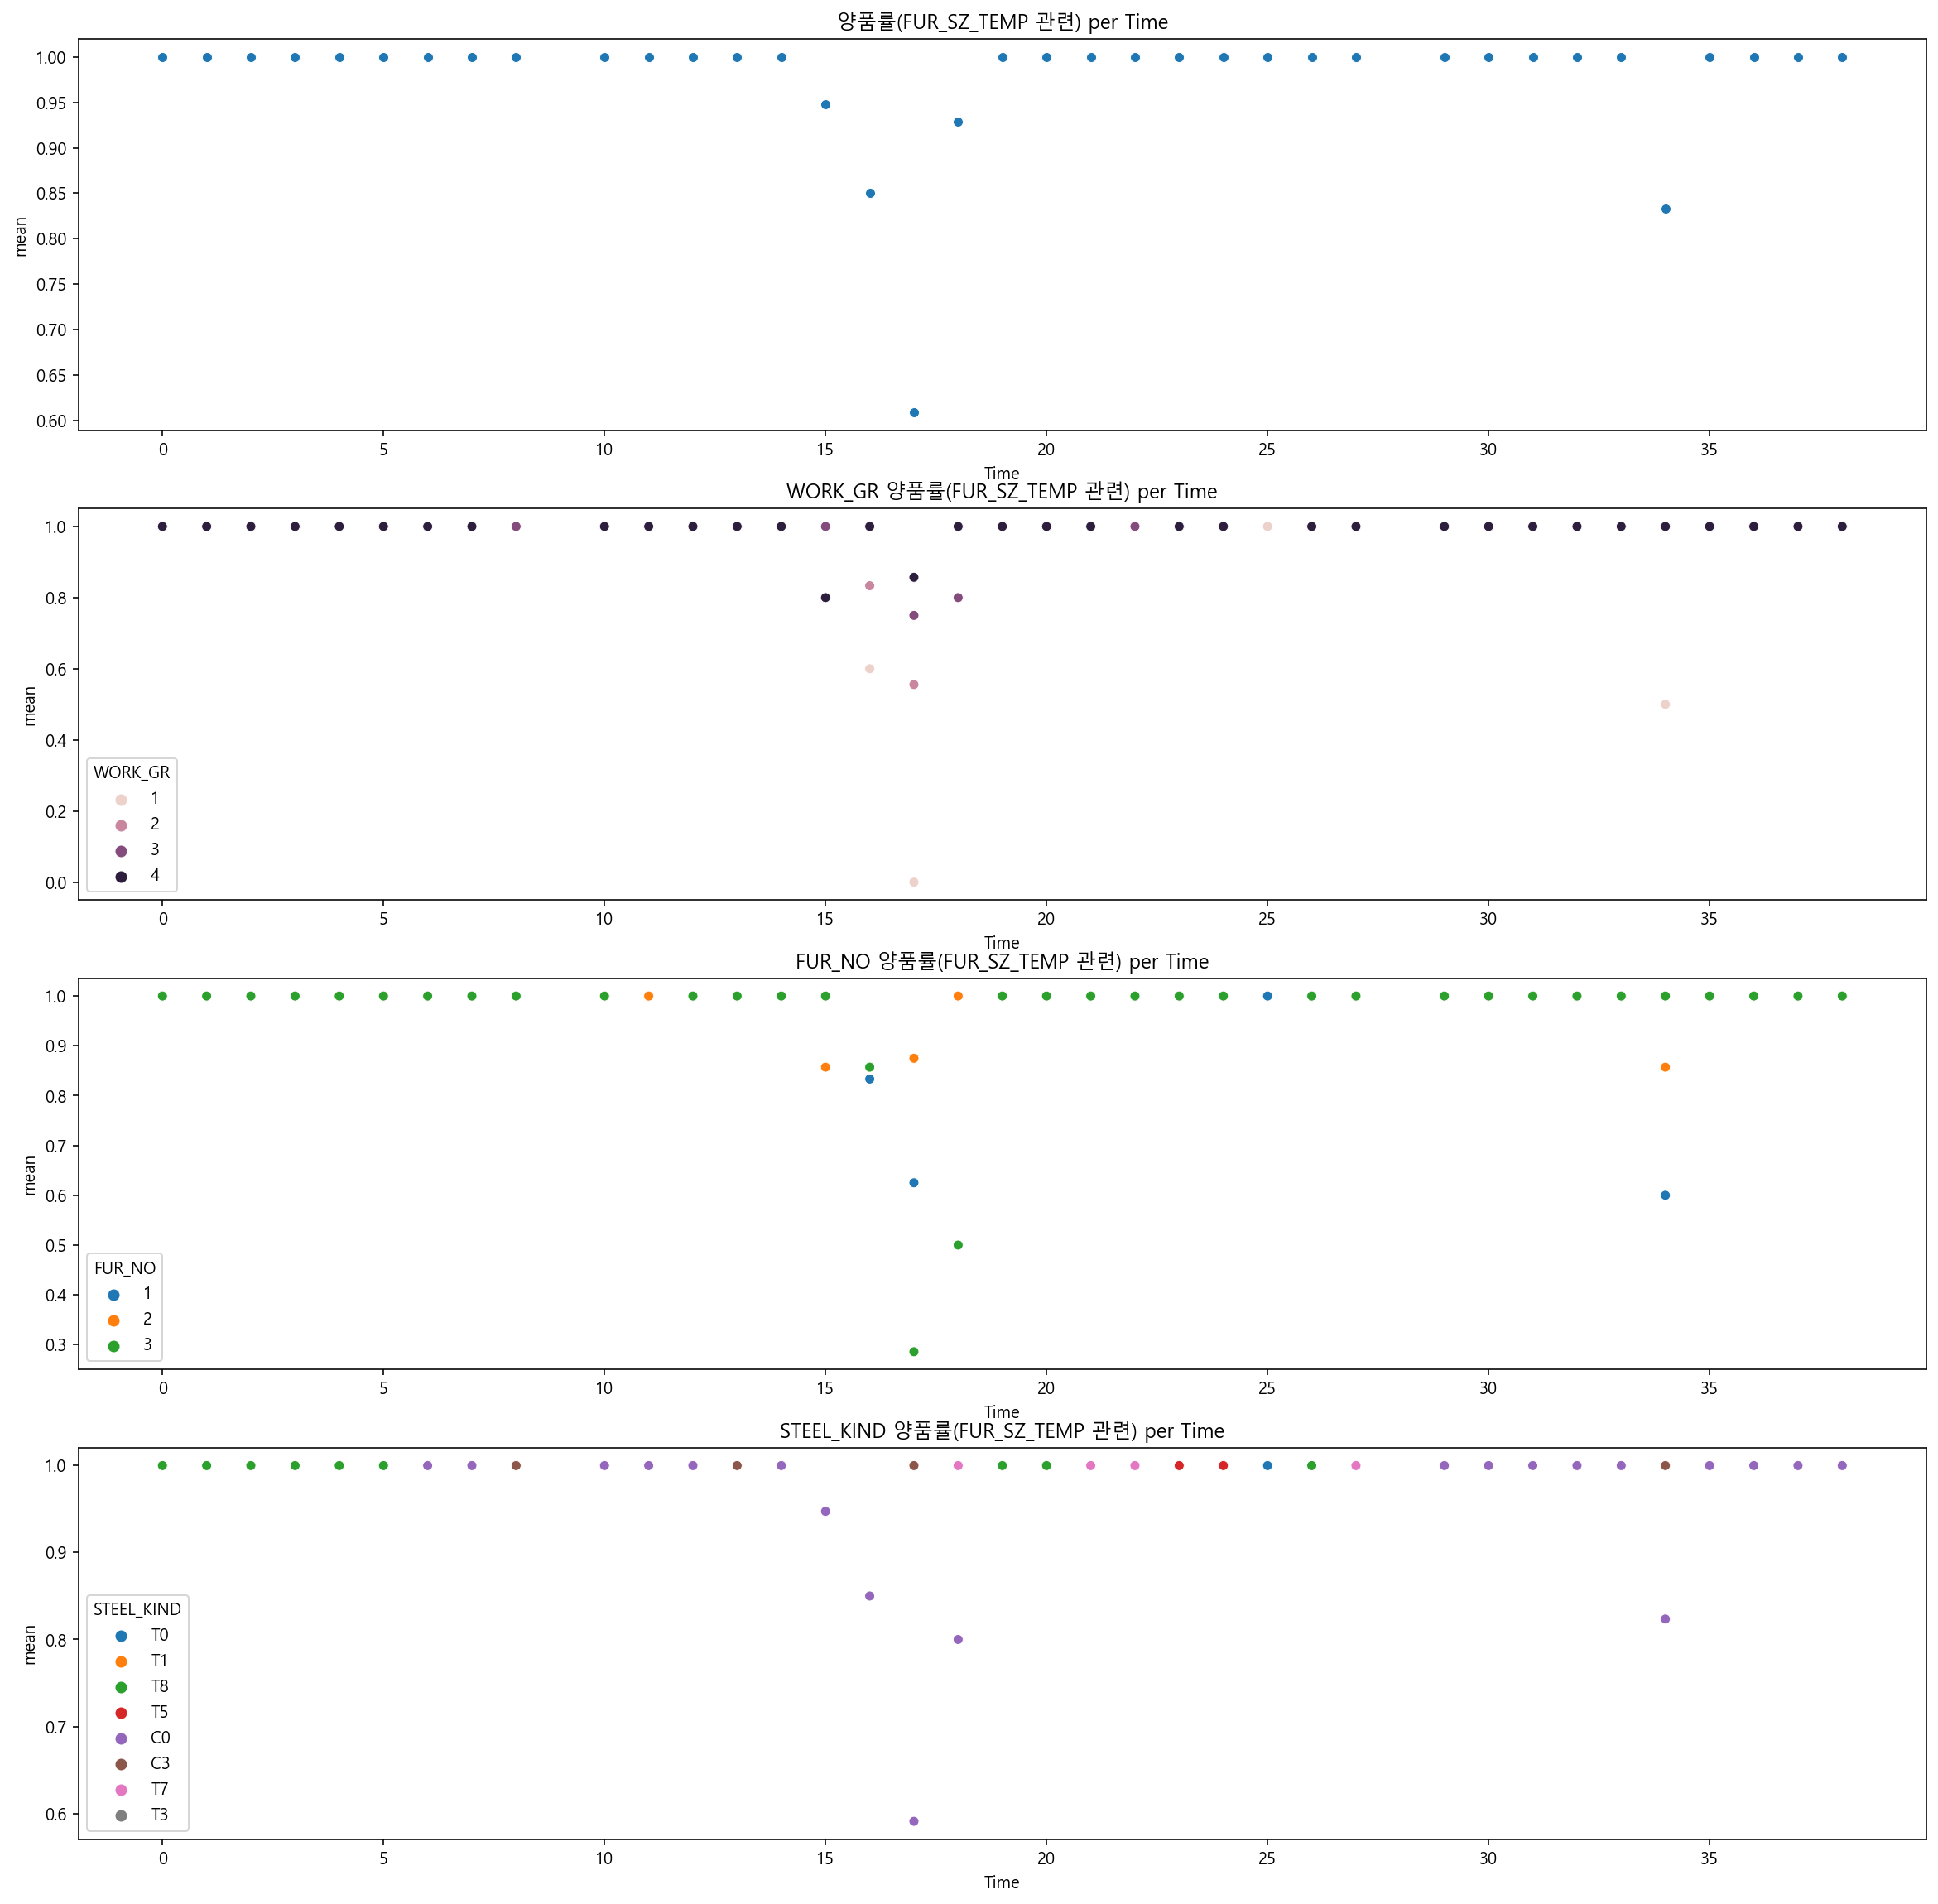

In [22]:
i=4
fig, ax = plt.subplots(nrows=i,figsize=(20,5*i))

sns.scatterplot(data=steel_extr_SZ1175.groupby('Time', as_index = False).agg(mean = ('SCALE', 'mean')), x ='Time', y = 'mean',ax=ax[0]).set_title('양품률(FUR_SZ_TEMP 관련) per Time')#.set(xlim = (14,36))
sns.scatterplot(data=steel_extr_SZ1175.groupby(['Time','WORK_GR'], as_index = False).agg(mean = ('SCALE', 'mean')), x ='Time', y = 'mean', hue='WORK_GR',ax=ax[1]).set_title('WORK_GR 양품률(FUR_SZ_TEMP 관련) per Time')
sns.scatterplot(data=steel_extr_SZ1175.groupby(['Time','FUR_NO'], as_index = False).agg(mean = ('SCALE', 'mean')), x ='Time', y = 'mean', hue='FUR_NO',ax=ax[2]).set_title('FUR_NO 양품률(FUR_SZ_TEMP 관련) per Time')
sns.scatterplot(data=steel_extr_SZ1175.groupby(['Time','STEEL_KIND'], as_index = False).agg(mean = ('SCALE', 'mean')), x ='Time', y = 'mean', hue='STEEL_KIND',ax=ax[3]).set_title('STEEL_KIND 양품률(FUR_SZ_TEMP 관련) per Time')

plt.show()

Text(0.5, 1.0, 'WORK_GR별 양품수,불량품수')

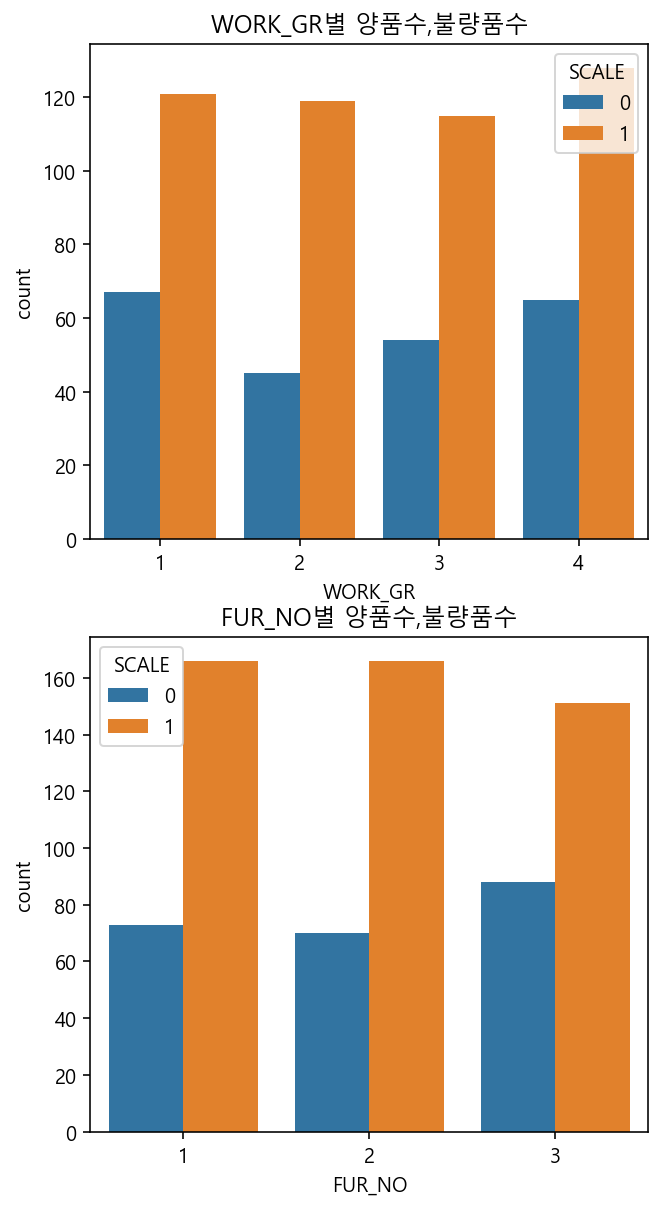

In [23]:
fig, ax = plt.subplots(nrows=2,figsize=(5,10))

sns.barplot(data=steel_data.groupby(['FUR_NO','SCALE'], as_index = False).agg(count = ('PLATE_NO', 'count')), x ='FUR_NO', y = 'count', hue='SCALE',ax=ax[1]).set_title('FUR_NO별 양품수,불량품수')
sns.barplot(data=steel_data.groupby(['WORK_GR','SCALE'], as_index = False).agg(count = ('PLATE_NO', 'count')), x ='WORK_GR', y = 'count', hue='SCALE',ax=ax[0]).set_title('WORK_GR별 양품수,불량품수')

* FUR_NO 3호기의 불량률이 다소 높은데 가열로 공정에 해당하는 FUR_NO는 FUR_SZ_TEMP와 관련있을 것임. 
* 위의 '시간별 FUR_NO 양품률(FUR_SZ_TEMP 관련)' 그래프를 보면 그 관계를 확인할 수 있다. 
* 15시부터 전체 FUR_NO에 문제가 생겼고 3호기의 문제가 확연히 큼을 볼 수 있다. 그후 문제를 잘 해결하였는지 33시에는 다른 호기와는 다르게 문제를 일으키지 않았다.
* 시간별 WORK_GR 양품률(FUR_SZ_TEMP 관련), 시간별 FUR_NO 양품률(FUR_SZ_TEMP 관련) 두 그래프 개형을 비교해 보면 어느시간에 어느 WORK_GR이 어느 FUR_NO에서 근무하였는지 알 수 있다. 예를 들어 15시에 FUR_NO 3호기에서 WORK_GR 1조가 근무했을 것이다.
* FUR_SZ_TEMP 관련 문제는 STEEL_KIND가 CO일떄만 생겼다.

### ROLLING_TEMP_T5 관련 양품률 per Time

Text(0.5, 1.0, ' STEEL_KIND 양품률(ROLLING_TEMP_T5 관련) per Time')

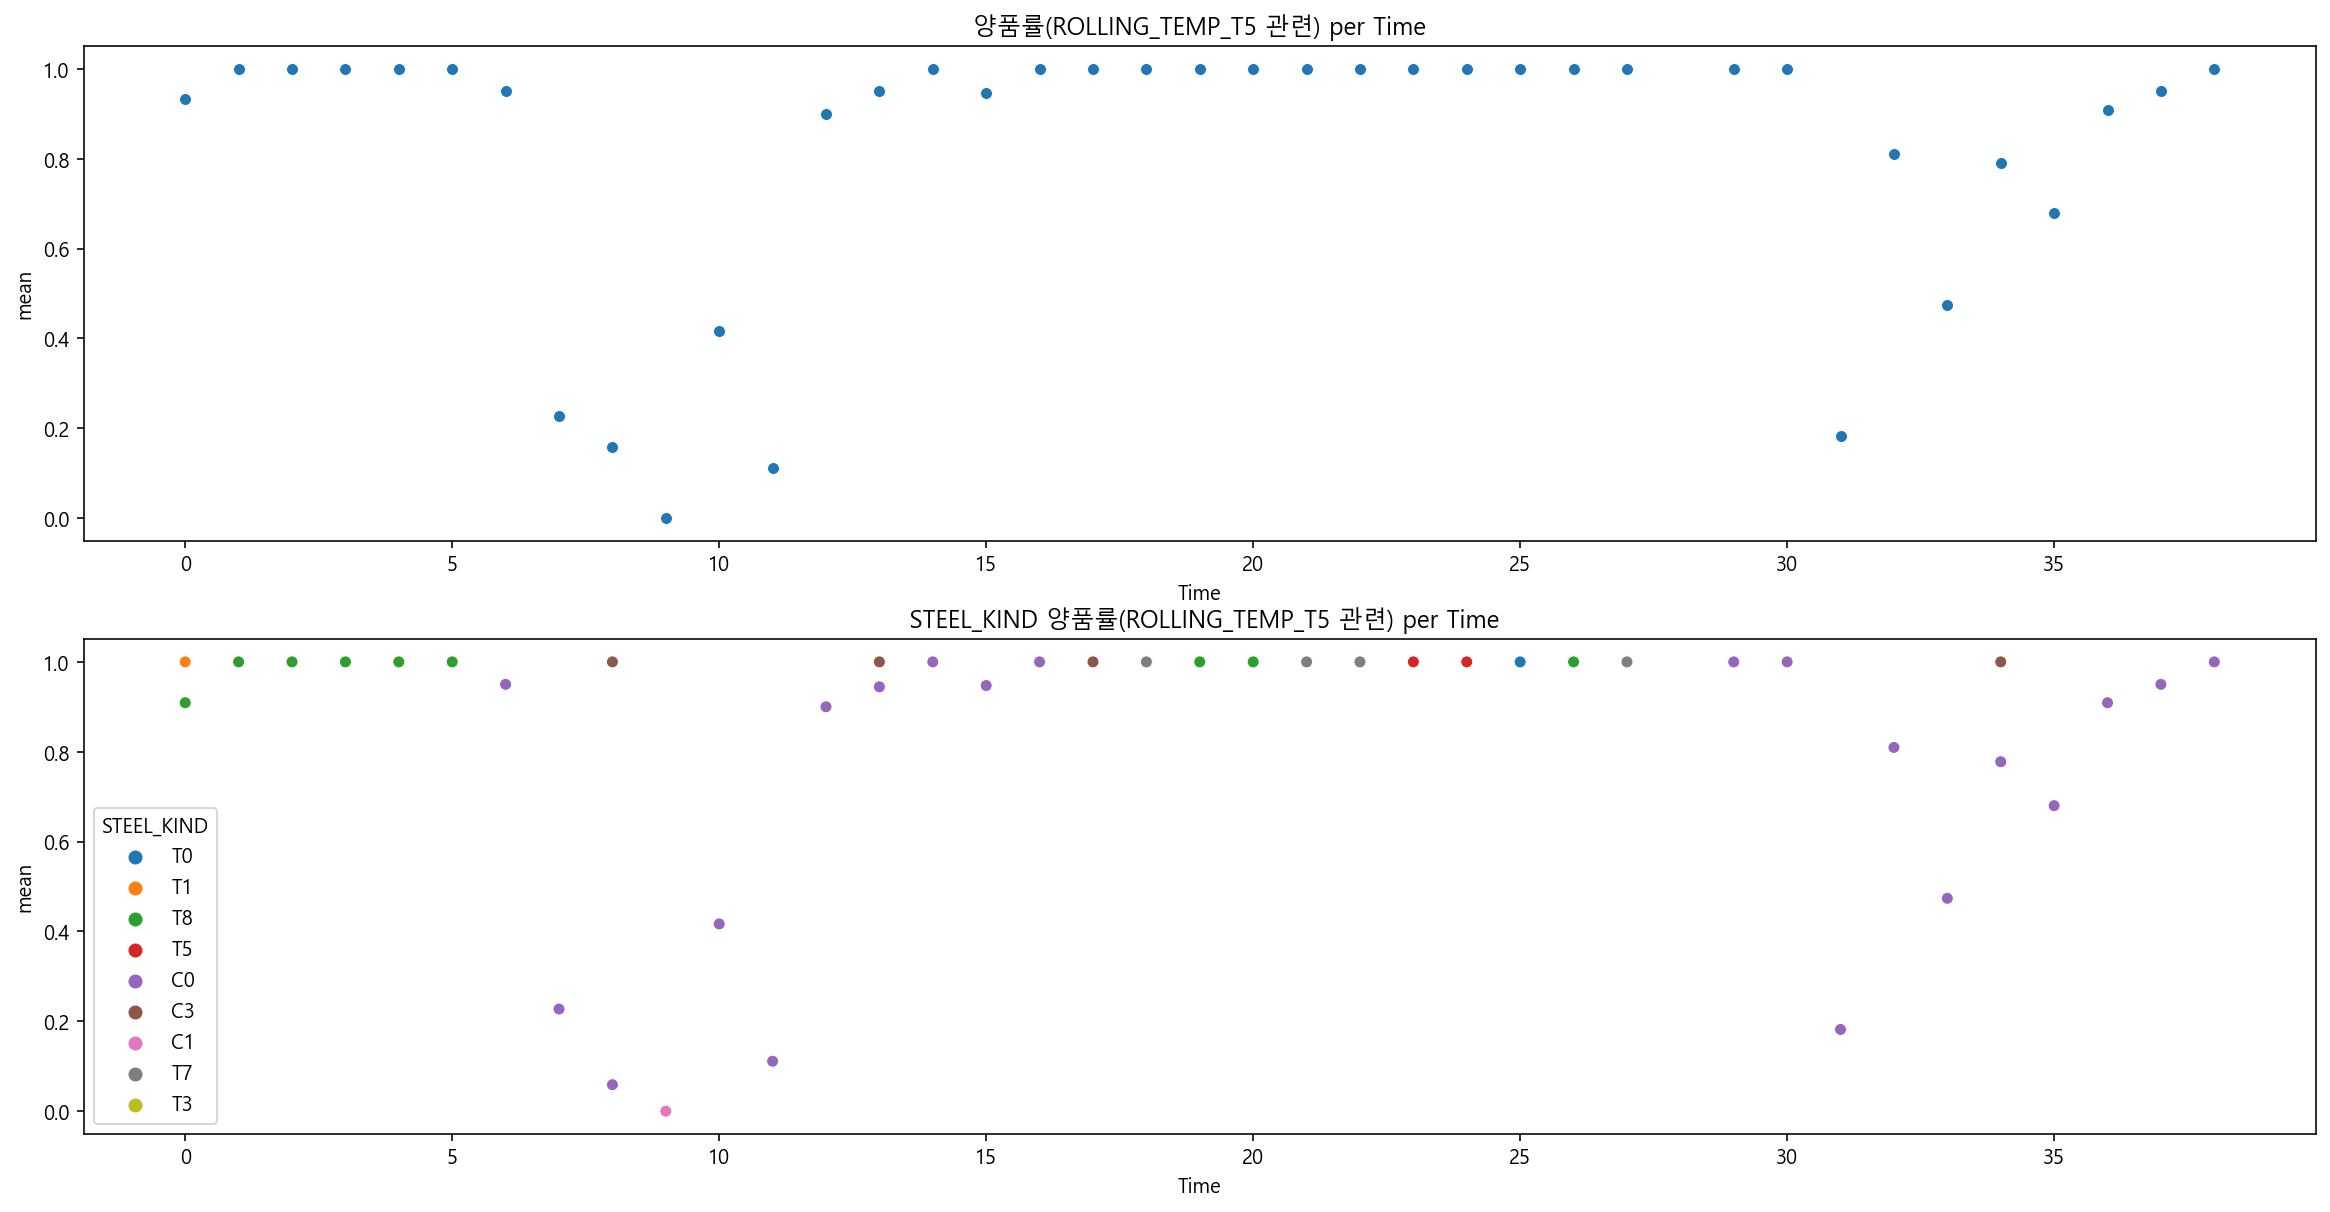

In [24]:
i=2
fig, ax = plt.subplots(nrows=i,figsize=(20,5*i))

sns.scatterplot(data=steel_extr_RT1000.groupby('Time', as_index = False).agg(mean = ('SCALE', 'mean')), x ='Time', y = 'mean',ax=ax[0]).set_title('양품률(ROLLING_TEMP_T5 관련) per Time')
sns.scatterplot(data=steel_extr_RT1000.groupby(['Time','STEEL_KIND'], as_index = False).agg(mean = ('SCALE', 'mean')), x ='Time', y = 'mean', hue='STEEL_KIND',ax=ax[1]).set_title(' STEEL_KIND 양품률(ROLLING_TEMP_T5 관련) per Time')

* ROLLING_TEMP_T5 관련한 불량률은 CO(501개/714개)와 많은 연관성을 가짐을 볼 수 있다. 그외에 1일00시 T8 1개, 1일22시 T7 1개 불량이 발생하였다. 그외 다른 STEEL_KIND들은 ROLLING_TEMP_T5공정관련해서는 문제없다.

## ROLLING_DESCALING, FUR_SZ_TEMP 관계

In [25]:
steel_data[steel_data['SZ1175']==0][['PLATE_NO','FUR_SZ_TEMP','ROLLING_DESCALING']]

,PLATE_NO,FUR_SZ_TEMP,ROLLING_DESCALING
332,PB563106,1176,7
336,PB563110,1177,9
337,PB563111,1176,10
338,PB563112,1176,10
346,PB563120,1179,10
357,PB563131,1178,10
358,PB563132,1185,9
363,PB563137,1178,10
364,PB563138,1183,10
368,PB563142,1181,10


* FUR_SZ_TEMP이 비정상일떄 ROLLING_DESCALING 값이 비교적 높다. ROLLING_DESCALING공정이 불순물을 제거하고자 하는 공정임을 보았을떄, FUR_SZ_TEMP 이 비정상일떄 제품에 불순물이 많이 함유되어 ROLLING_DESCALING 횟수를 증가시켰을 가능성이 있다.

## 4개 스위치_공정의 pass/fail에 관여되는 변인

* FUR_NO, FUR_NO_ROW, WORK_GR 세 칼럼을 변인으로 추정.

Text(0.5, 1.0, 'WORK_GR 별 스위치_공정 정상률')

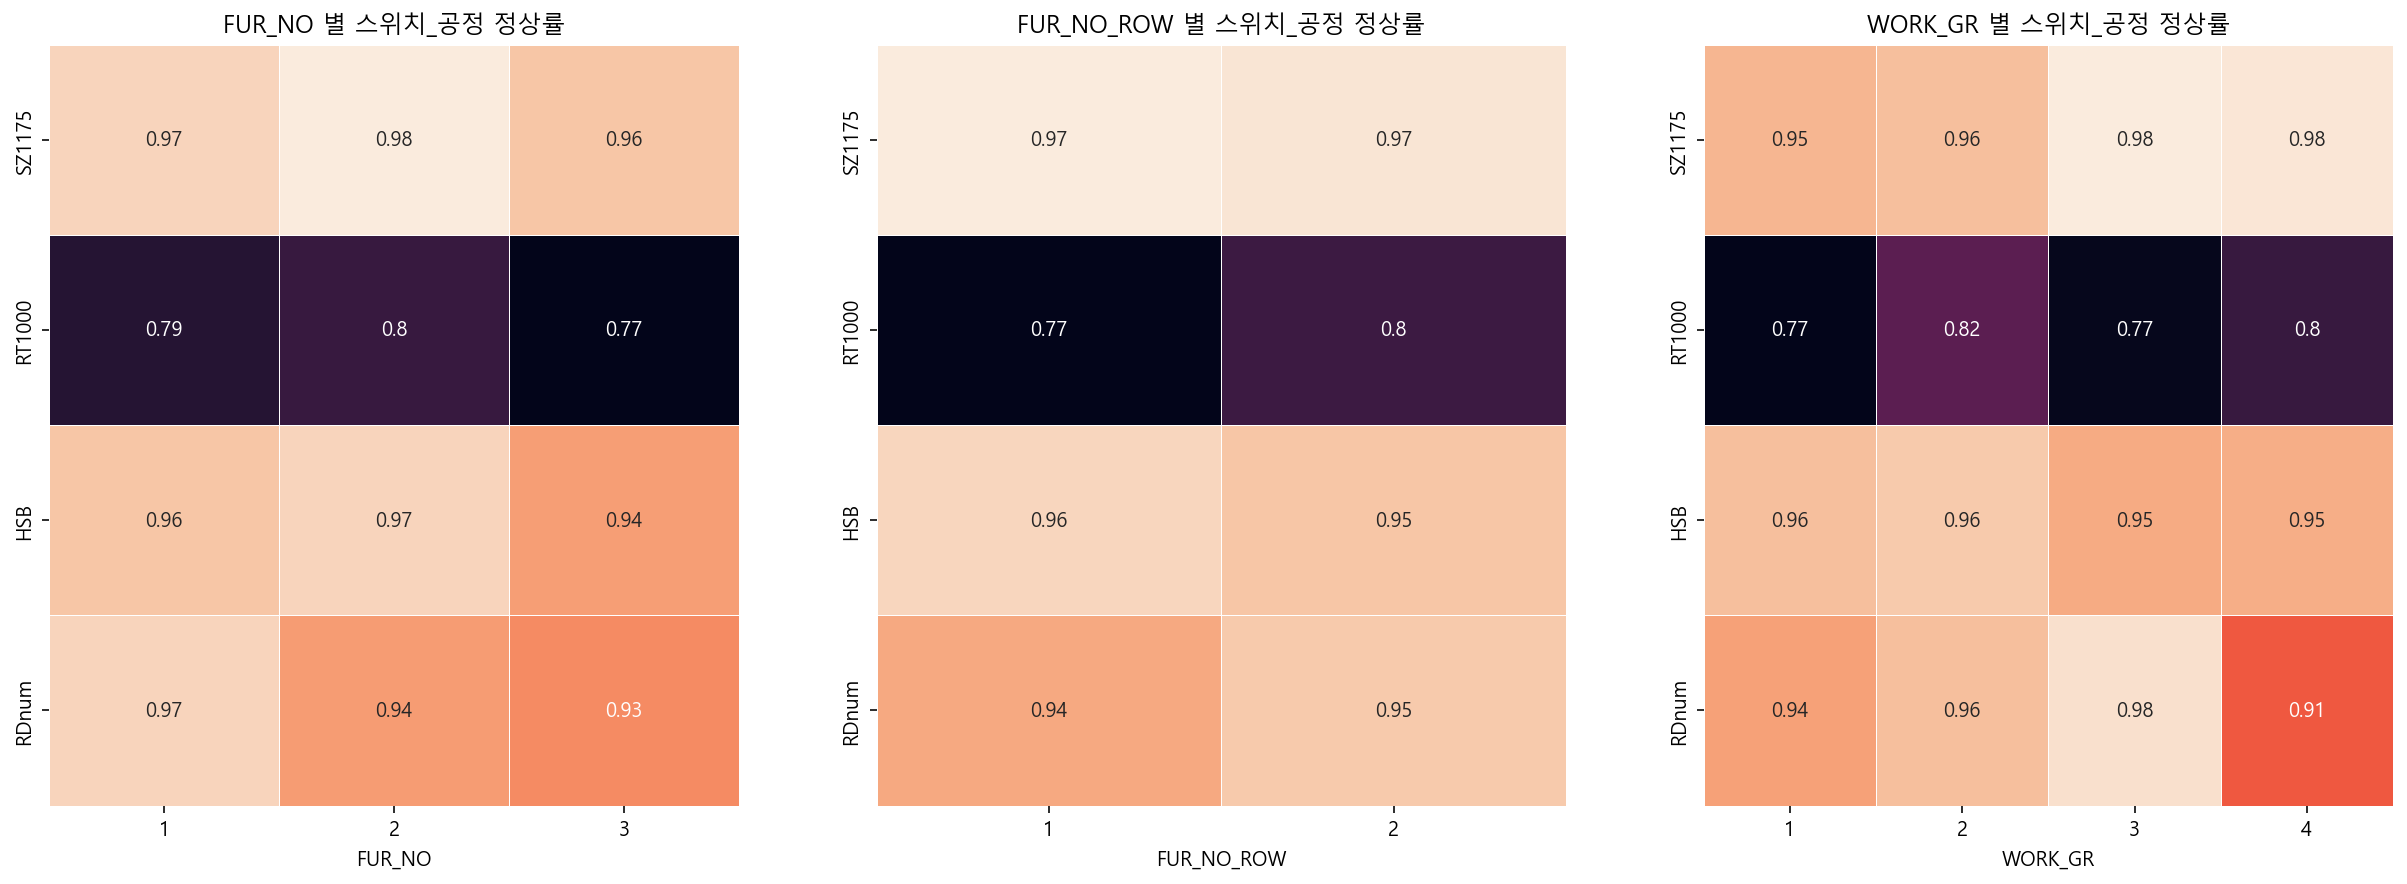

In [26]:
i=3
fig, ax = plt.subplots(ncols=i,figsize=(7*i,7))

sns.heatmap(steel_data.groupby('FUR_NO')['SZ1175', 'RT1000', 'HSB', 'RDnum'].mean().T, annot=True, cbar=False, linewidths= 0.5, ax=ax[0]).set_title('FUR_NO 별 스위치_공정 정상률')
sns.heatmap(steel_data.groupby('FUR_NO_ROW')['SZ1175', 'RT1000', 'HSB', 'RDnum'].mean().T, annot=True, cbar=False, linewidths= 0.5, ax=ax[1]).set_title('FUR_NO_ROW 별 스위치_공정 정상률')
sns.heatmap(steel_data.groupby('WORK_GR')['SZ1175', 'RT1000', 'HSB', 'RDnum'].mean().T, annot=True, cbar=False, linewidths= 0.5, ax=ax[2]).set_title('WORK_GR 별 스위치_공정 정상률')

* 코멘트

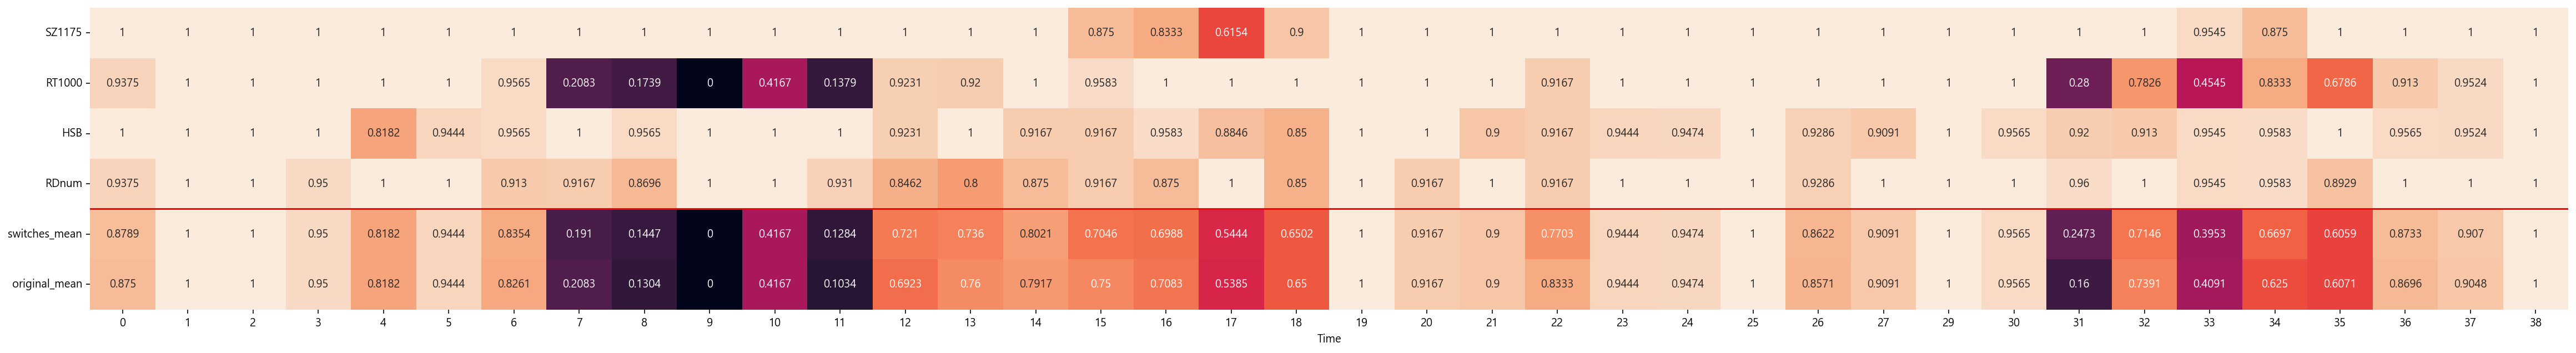

In [27]:
fig, ax = plt.subplots(figsize=(40,5))
aa = steel_data.groupby('Time',)['SZ1175', 'RT1000', 'HSB', 'RDnum'].mean()
aa['switches_mean'] = aa.apply((lambda x: (x['SZ1175'])*(x['RT1000'])*(x['HSB'])*(x['RDnum'])), axis=1)  
aa['original_mean'] = steel_data.groupby('Time').agg(mean=('SCALE','mean'))
sns.heatmap(aa.T, annot=True, fmt='.4g', cbar=False)
plt.axhline(4, color='r')
plt.show()

* 빨간선 위의 각각의 셀이 의미하는것 : 시간대 별 스위치_공정 각각의 공정 정상률
* switches_mean : 시간대 별 각각 공정 정상률을 곱한 값
* original_mean : 원본데이터의 시간대 별 양품률
* 이 두개는 보통 같은 값을 가질것이라 예상하고 대부분은 그러한데, 몇몇 구간에서는 다른 값을 가지고 있음을 볼 수 있다. -> 그 구간에서는 2개 이상(3,4개는 데이터상에 없다.)의 공정에 오류가 생긴 것.  

Text(0.5, 1.0, '7시~11시, 31시~35시의 ROLLING_TEMP_T5 분포도')

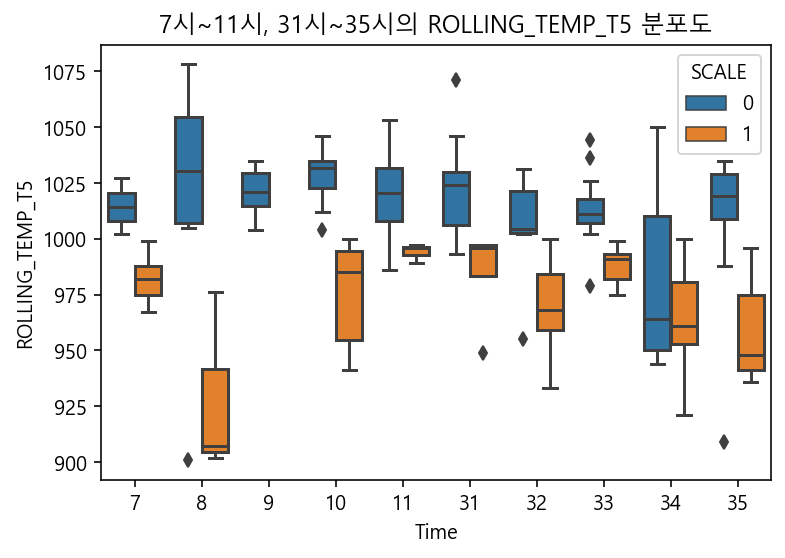

In [28]:
# 수율이 비교적 낮은 구간이 보이는데 그에 해당하는 7시~11시, 31시~35시 구간의 dominant한 요소는 ROLLING_TEMP_T5이라 판단.  
sns.boxplot(data=steel_data[((7<=steel_data['Time'])&(steel_data['Time']<=11))|((31<=steel_data['Time'])&(steel_data['Time']<=35))], x='Time', y='ROLLING_TEMP_T5',hue='SCALE').set_title('7시~11시, 31시~35시의 ROLLING_TEMP_T5 분포도')

In [29]:
""" import plotly.express as px

fig = px.imshow(aa.T)
plt.axhline(4, color='r')
fig.show() """

" import plotly.express as px\n\nfig = px.imshow(aa.T)\nplt.axhline(4, color='r')\nfig.show() "

## Dencity

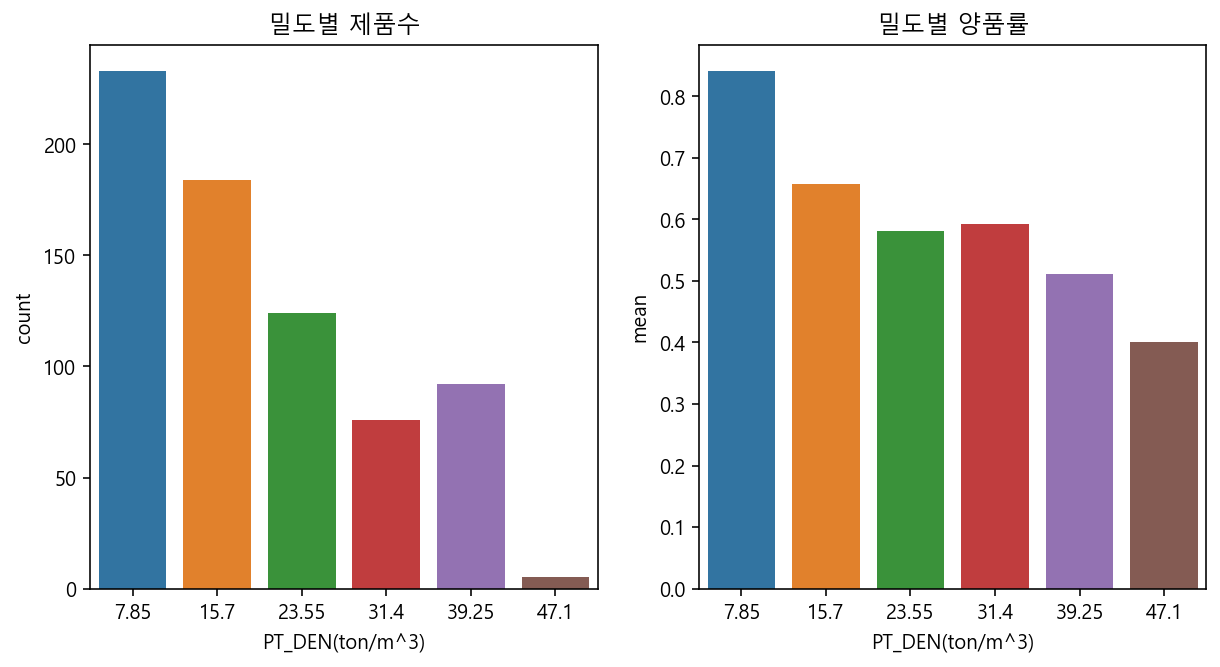

In [30]:
fig, ax = plt.subplots(ncols=2,figsize=(10,5))

sns.barplot(data=steel_data.groupby('PT_DEN(ton/m^3)', as_index = False).agg(count = ('PLATE_NO', 'count')), x ='PT_DEN(ton/m^3)', y = 'count',ax=ax[0]).set_title('밀도별 제품수')
sns.barplot(data=steel_data.groupby('PT_DEN(ton/m^3)', as_index = False).agg(mean = ('SCALE', 'mean')), x ='PT_DEN(ton/m^3)', y = 'mean',ax=ax[1]).set_title('밀도별 양품률')
plt.show()

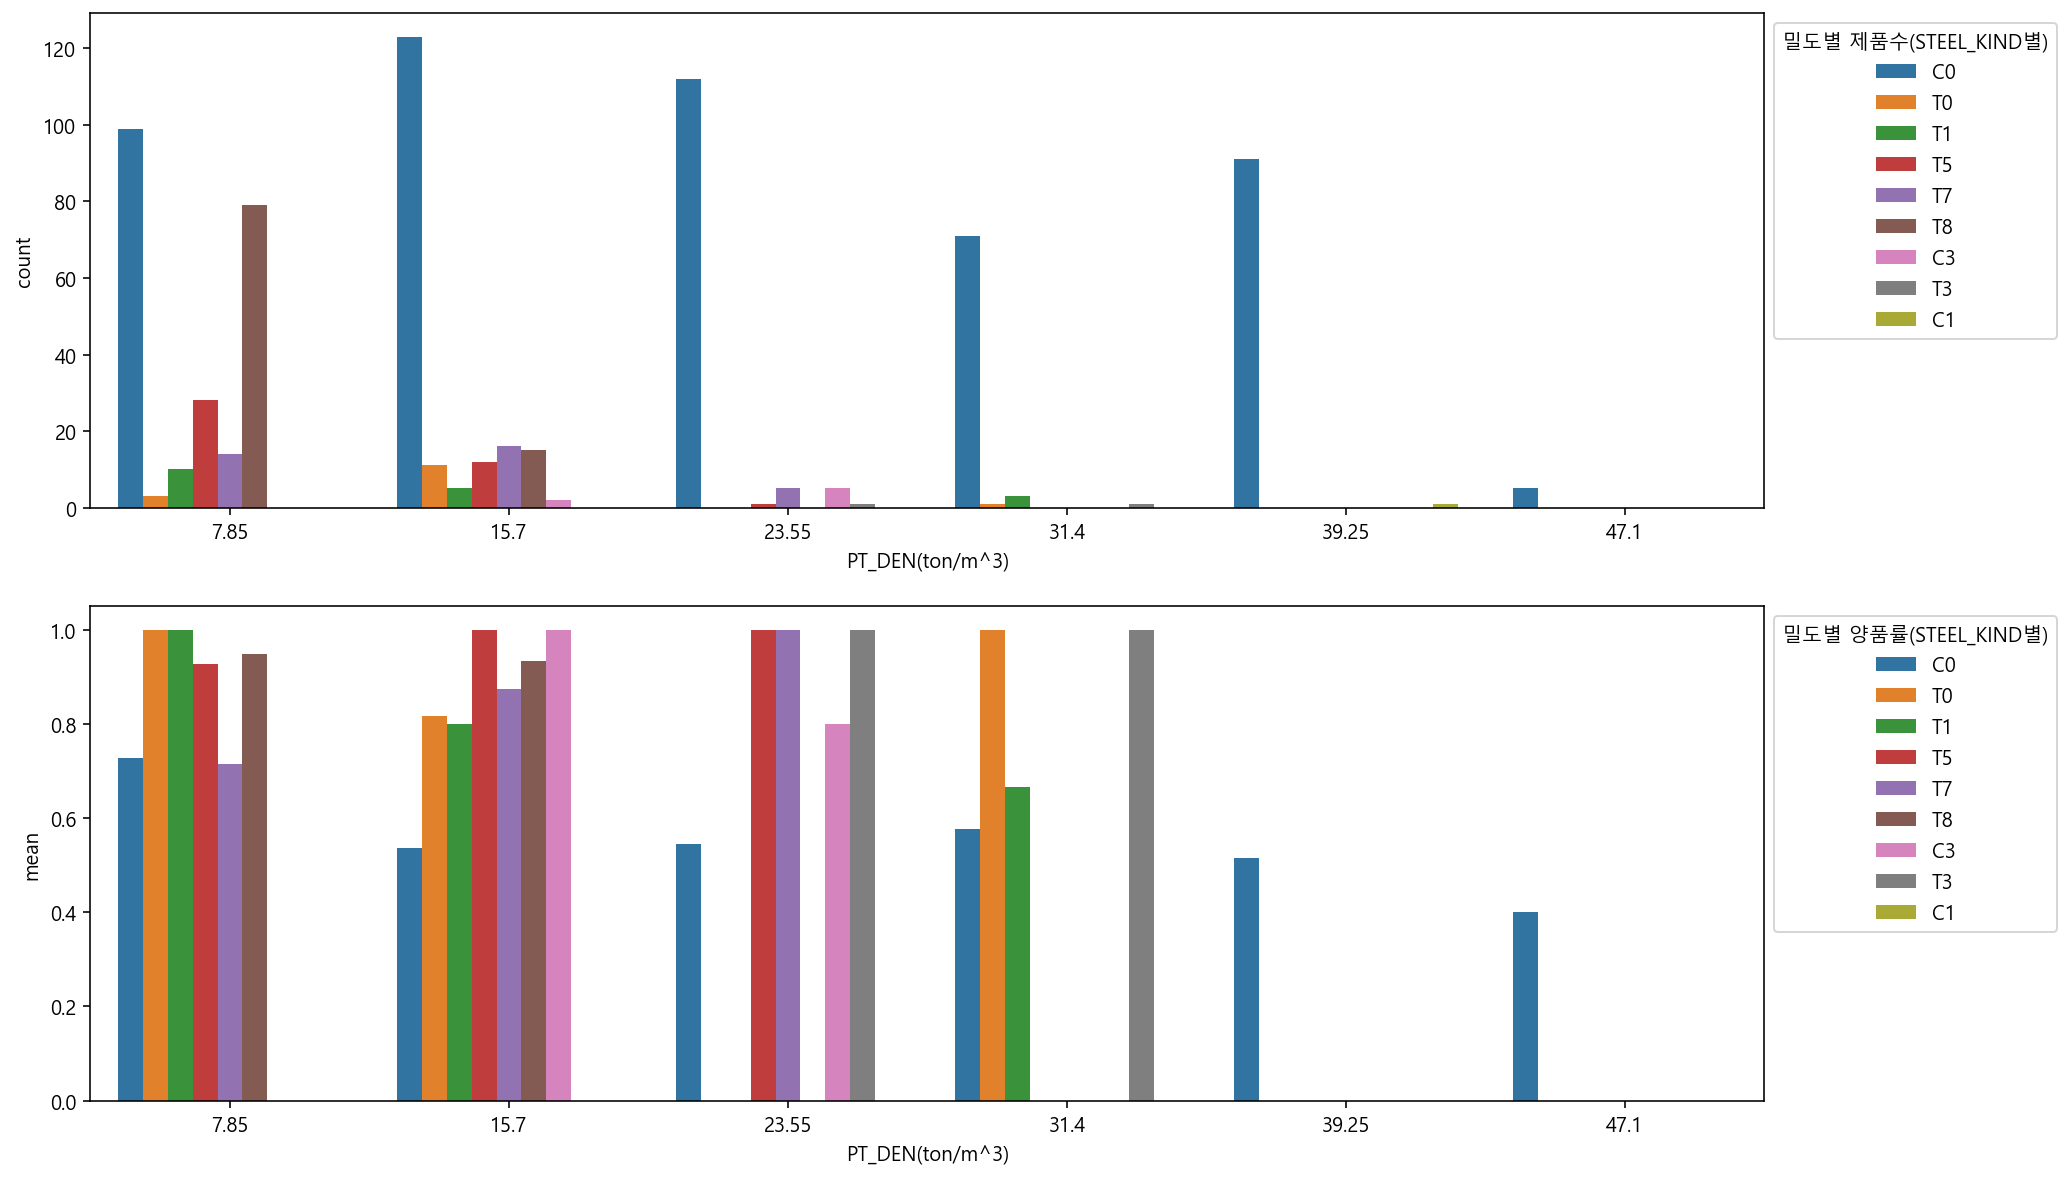

In [31]:
fig, ax = plt.subplots(nrows=2,figsize=(15,10))

sns.barplot(data=steel_data.groupby(['PT_DEN(ton/m^3)','STEEL_KIND'], as_index = False).agg(count = ('PLATE_NO', 'count')), x ='PT_DEN(ton/m^3)', y = 'count', hue='STEEL_KIND', ax=ax[0])\
    .legend(loc = 2, bbox_to_anchor = (1,1)).set_title('밀도별 제품수(STEEL_KIND별)')
sns.barplot(data=steel_data.groupby(['PT_DEN(ton/m^3)','STEEL_KIND'], as_index = False).agg(mean = ('SCALE', 'mean')), x ='PT_DEN(ton/m^3)', y = 'mean', hue='STEEL_KIND', ax=ax[1])\
    .legend(loc = 2, bbox_to_anchor = (1,1)).set_title('밀도별 양품률(STEEL_KIND별)')
plt.show()

* 밀도와 STEEL_KIND간의 관계가 있을 것이라 생각했는데, 소수점4자리까지도 유의미한 결과는 도출되지 않았다.
* 소수점 2자리로 반올림하니 카테고리컬한 자료가 되었는데, 강철의 밀도차가 이런식으로 구분되는 것은 불가능하다. 따라서 데이터원본의 제품 물성에 관한 값들이 실제데이터에서 다소 변주 되었음을 확인할 수 있다. 

## SPEC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


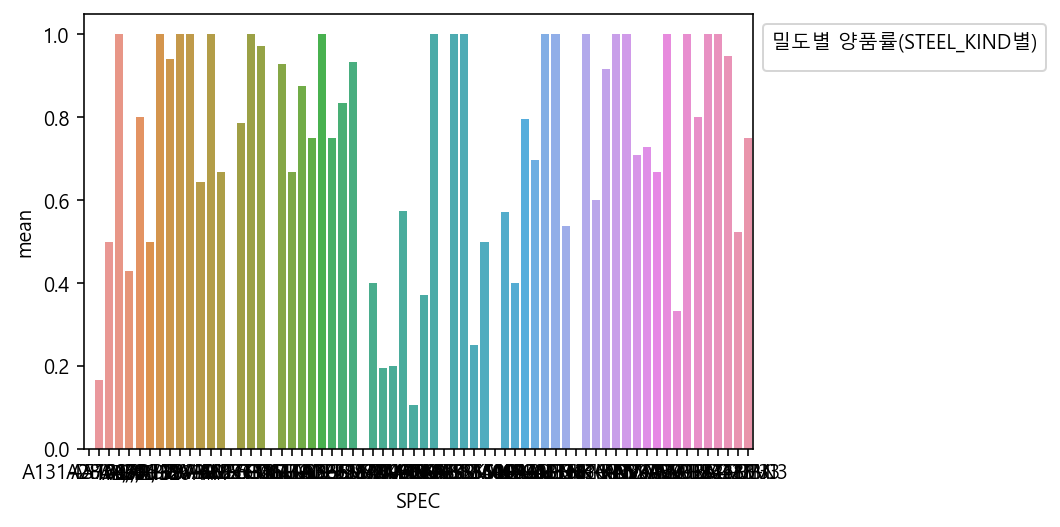

In [32]:
sns.barplot(data=steel_data.groupby(['SPEC'], as_index = False).agg(mean = ('SCALE', 'mean')), x ='SPEC', y = 'mean')\
    .legend(loc = 2, bbox_to_anchor = (1,1)).set_title('밀도별 양품률(STEEL_KIND별)')

In [33]:
steel_spec_mean = steel_data.groupby(['SPEC'], as_index = False).agg(spec_mean = ('SCALE', 'mean'))
steel_spec_count = steel_data.groupby(['SPEC'], as_index = False).agg(spec_count = ('PLATE_NO', 'count'))
steel_spec = pd.merge(steel_spec_mean,steel_spec_count,on='SPEC')
steel_spec[steel_spec['spec_mean']<0.5]

,SPEC,spec_mean,spec_count
0,A131-DH36TM,0.000000,1
1,A283-C,0.166667,6
4,AB/A,0.428571,7
14,BV-AH36-TM,0.000000,1
18,CCS-B,0.000000,1
27,JS-SM400A,0.000000,2
28,JS-SM400B,0.400000,5
29,JS-SM490A,0.193548,31
30,JS-SM490YA,0.200000,5
32,JS-SS400,0.105263,19


* 양품률이 절반 밑인, 즉 제작난이도가 높은 SPEC들을 추려보았다. # 저 목록에 있는 SPEC에 해당하는 제품들 SZ1175, HSB, RDnum, RT1000 값들 이용해 표만들어주거나 시각화 시도해 주세요.

# Clustring     

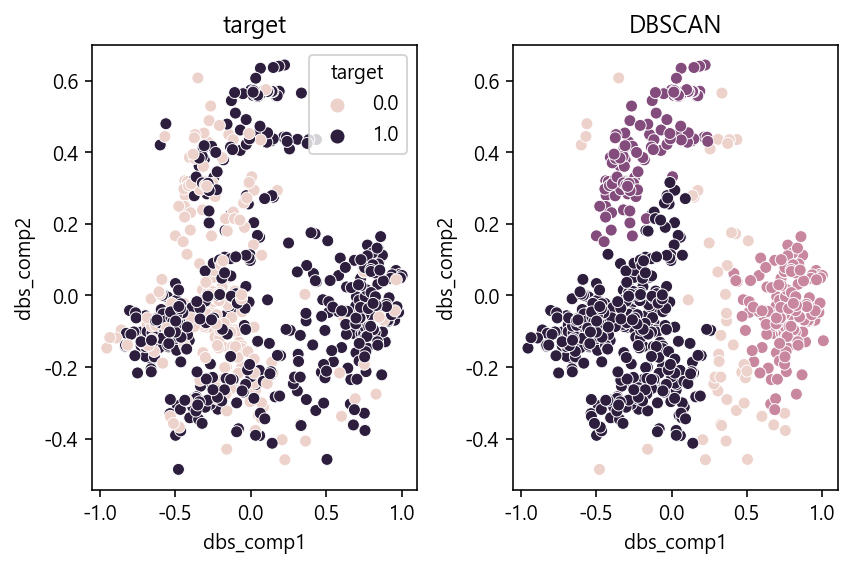

In [34]:
x = steel_data[['FUR_HZ_TEMP','FUR_HZ_TIME','FUR_SZ_TEMP', 'FUR_TIME', 'FUR_EXTEMP','FUR_SZ_TIME','ROLLING_DESCALING','ROLLING_TEMP_T5','HSB']]

from sklearn.preprocessing import MinMaxScaler
scaler_steel = MinMaxScaler()
scaler_steel.fit(x)
x_scaled=scaler_steel.transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=2) 
pca.fit(x_scaled)
x_scaled_pca = pca.transform(x_scaled)

from sklearn.cluster import DBSCAN
dbs = DBSCAN(min_samples = 10, eps=0.1)
dbs.fit(x_scaled_pca)
label_dbs = dbs.labels_

dbs_columns = ['dbs_comp1', 'dbs_comp2']
X_dbs_df = pd.DataFrame(x_scaled_pca, columns=dbs_columns)
X_dbs_df['label_dbs'] = label_dbs
X_dbs_df['target'] = steel_data['SCALE']

fig, axes = plt.subplots(1, 2)
sns.scatterplot(
    data = X_dbs_df, x = 'dbs_comp1', y = 'dbs_comp2', hue = 'target', ax = axes[0]
    ).set(title='target')
sns.scatterplot(
    data = X_dbs_df, x = 'dbs_comp1', y = 'dbs_comp2', hue = 'label_dbs', ax = axes[1]
    ).set(title='DBSCAN')
fig.tight_layout()
plt.legend([],[], frameon=False)

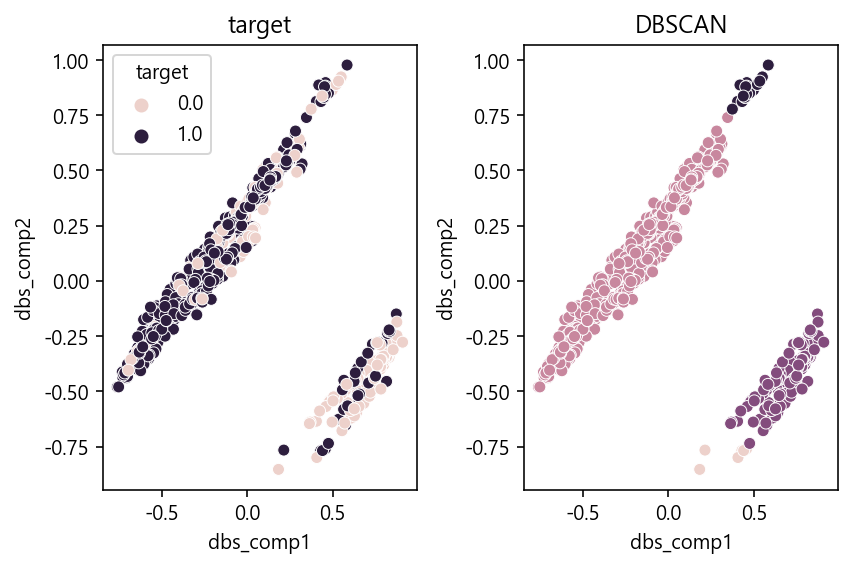

In [35]:
x = steel_data[['FUR_HZ_TEMP','FUR_HZ_TIME','FUR_SZ_TEMP', 'FUR_TIME', 'FUR_EXTEMP','SZ1175','RDnum','RT1000','HSB']]

from sklearn.preprocessing import MinMaxScaler
scaler_steel = MinMaxScaler()
scaler_steel.fit(x)
x_scaled=scaler_steel.transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=2) 
pca.fit(x_scaled)
x_scaled_pca = pca.transform(x_scaled)

from sklearn.cluster import DBSCAN
dbs = DBSCAN(min_samples = 10, eps=0.1)
dbs.fit(x_scaled_pca)
label_dbs = dbs.labels_

dbs_columns = ['dbs_comp1', 'dbs_comp2']
X_dbs_df = pd.DataFrame(x_scaled_pca, columns=dbs_columns)
X_dbs_df['label_dbs'] = label_dbs
X_dbs_df['target'] = steel_data['SCALE']

fig, axes = plt.subplots(1, 2)
sns.scatterplot(
    data = X_dbs_df, x = 'dbs_comp1', y = 'dbs_comp2', hue = 'target', ax = axes[0]
    ).set(title='target')
sns.scatterplot(
    data = X_dbs_df, x = 'dbs_comp1', y = 'dbs_comp2', hue = 'label_dbs', ax = axes[1]
    ).set(title='DBSCAN')
fig.tight_layout()
plt.legend([],[], frameon=False)

다소 중구난방인 원본데이터의 클러스터링보다 ROLLING_DESCALING, ROLLING_TEMP_T5, HSB, FUR_SZ_TIME 네 칼럼을 on/off 스위치형자료로 변환한 데이터에서는 클러스터링이 잘보인다.

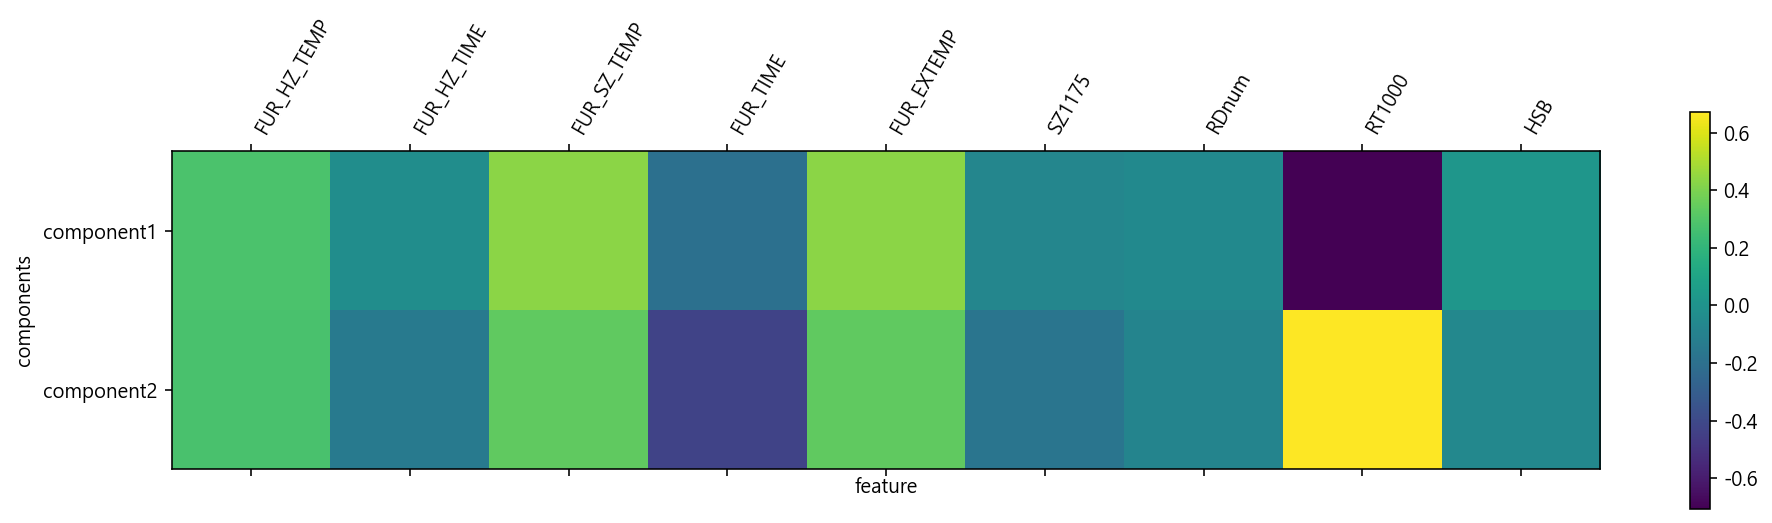

In [36]:
import matplotlib.pyplot as plt
plt.matshow(pca.components_, cmap = 'viridis')
plt.yticks([0,1], ['component1', 'component2'])
plt.colorbar()
plt.xticks(range(len(x.columns)),
          x.columns, rotation = 60, ha = 'left')
plt.xlabel('feature')
plt.ylabel('components')
plt.show()

# Machine Learning

* FUR_SZ_TIME, ROLLING_TEMP_T5, HSB, ROLLING_DESCALING 네개 칼럼들 핸들링한 데이터를 추출해 머신러닝을 돌려보니, 그 네 칼럼 제외하고 양품률에 관여하는 요소가 없어 의미가 없었음. 그래서 추출전 데이터를 활용해 머신러닝을 돌려보겠음.
* DecisionTree 모델에서 좋은 결과가 기대됨.  

In [37]:
from sklearn.model_selection import train_test_split

X = steel_data[['FUR_NO', 'FUR_NO_ROW', 'FUR_HZ_TEMP','FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP', 'WORK_GR','ROLLING_TEMP_T5','HSB','ROLLING_DESCALING']]
Y = steel_data['SCALE'] # 목표 = 양품Scale

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)

## DecisionTree (원본데이터 이용)

In [38]:
from sklearn.tree import DecisionTreeClassifier
#for i in range(1,6):
i=4
dtc = DecisionTreeClassifier(max_depth =i)
dtc.fit(X_train,Y_train)
pred_rf = dtc.predict(X_test)

dtc_train_score = dtc.score(X_train, Y_train)
dtc_test_score = dtc.score(X_test, Y_test)
print(f'max_depth = {i},  dtc_train_score : {round(dtc_train_score,3)}, dtc_test_score : {round(dtc_test_score,3)}, delta : {round(dtc_train_score-dtc_test_score,3)}')

max_depth = 4,  dtc_train_score : 0.967, dtc_test_score : 0.979, delta : -0.012


In [39]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, pred_rf)
print(conf_matrix)

from sklearn.metrics import classification_report
class_report = classification_report(Y_test, pred_rf)
print(class_report)

[[ 39   3]
 [  0 101]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       0.97      1.00      0.99       101

    accuracy                           0.98       143
   macro avg       0.99      0.96      0.97       143
weighted avg       0.98      0.98      0.98       143



C:\Users\BECK\AppData\Local\Temp\ipykernel_25700\2715364660.py:4: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



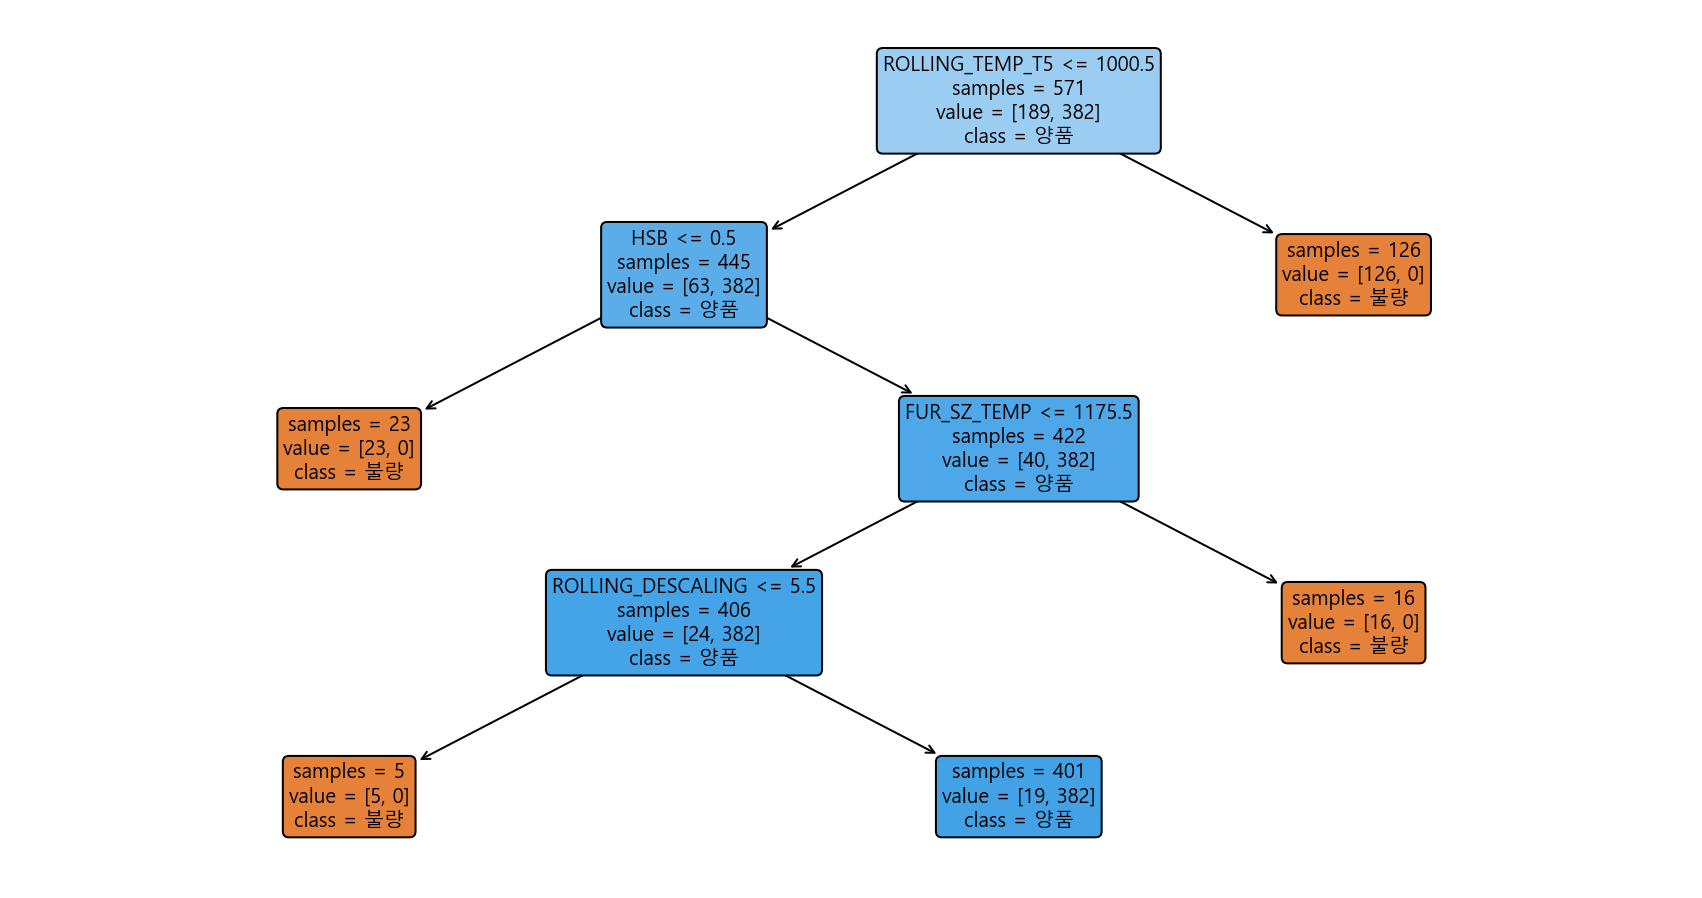

In [40]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")
plt.rcParams['figure.figsize'] = [15,8]

plot_tree(dtc, class_names=["불량", "양품"],
          feature_names=dtc.feature_names_in_,
         impurity=False, filled=True, rounded=True, fontsize=10)

plt.show()

* 흥미롭게도 ROLLING_TEMP_T5 >< 1000 , HSB 실행유무 , FUR_SZ_TEMP >< 1175 세가지 Decision분기를 확인할 수 있음. 다만 ROLLING_DESCALING 분기에서 디시전factor를 5개 이상 이하로 판단했음이 아쉽다. 
* 가공되지않은 데이터로 머신러닝을 돌리고 그 값를 이용해 데이터전처리를 돌려보았으면 더 쉽고 빠르게 결과를 도출할수 있었을 것같음. 

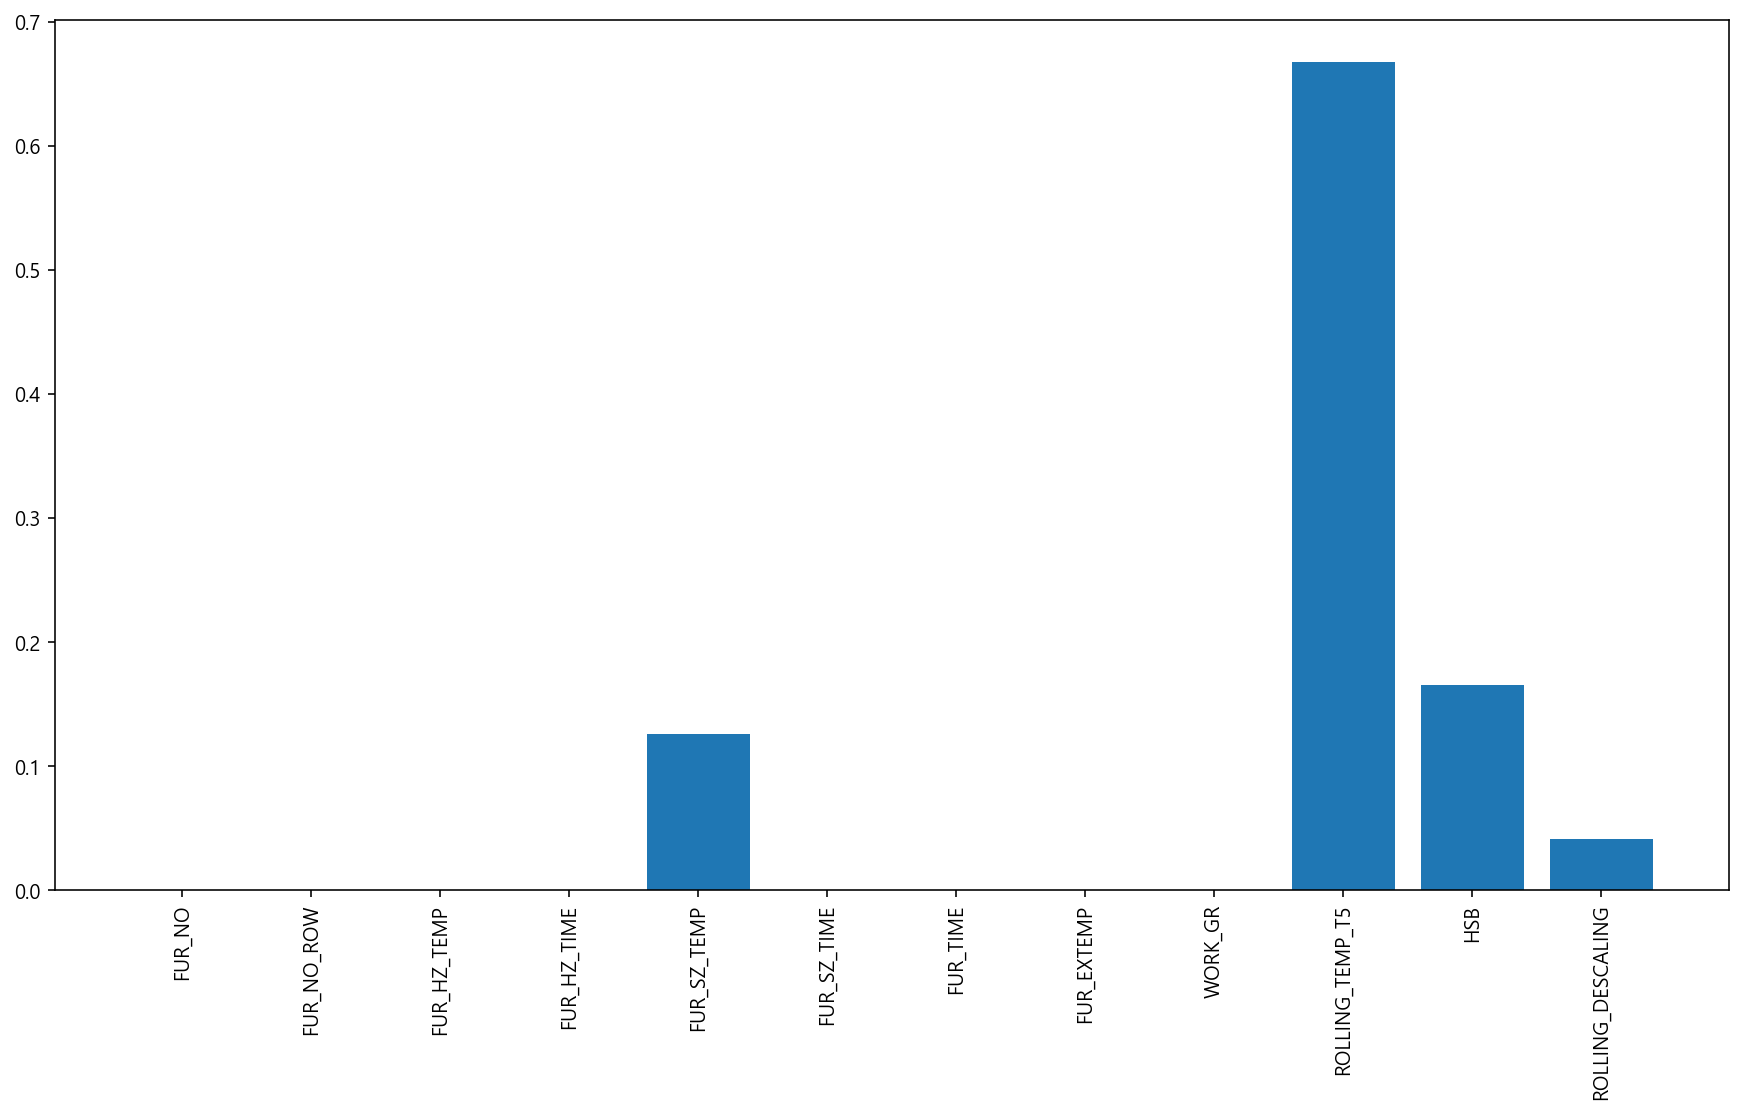

In [41]:
importance = dtc.feature_importances_
importance
plt.figure()
plt.bar(range(len(importance)),importance)
plt.xticks(range(len(importance)),X.columns,rotation=90)
plt.show()

<BarContainer object of 4 artists>

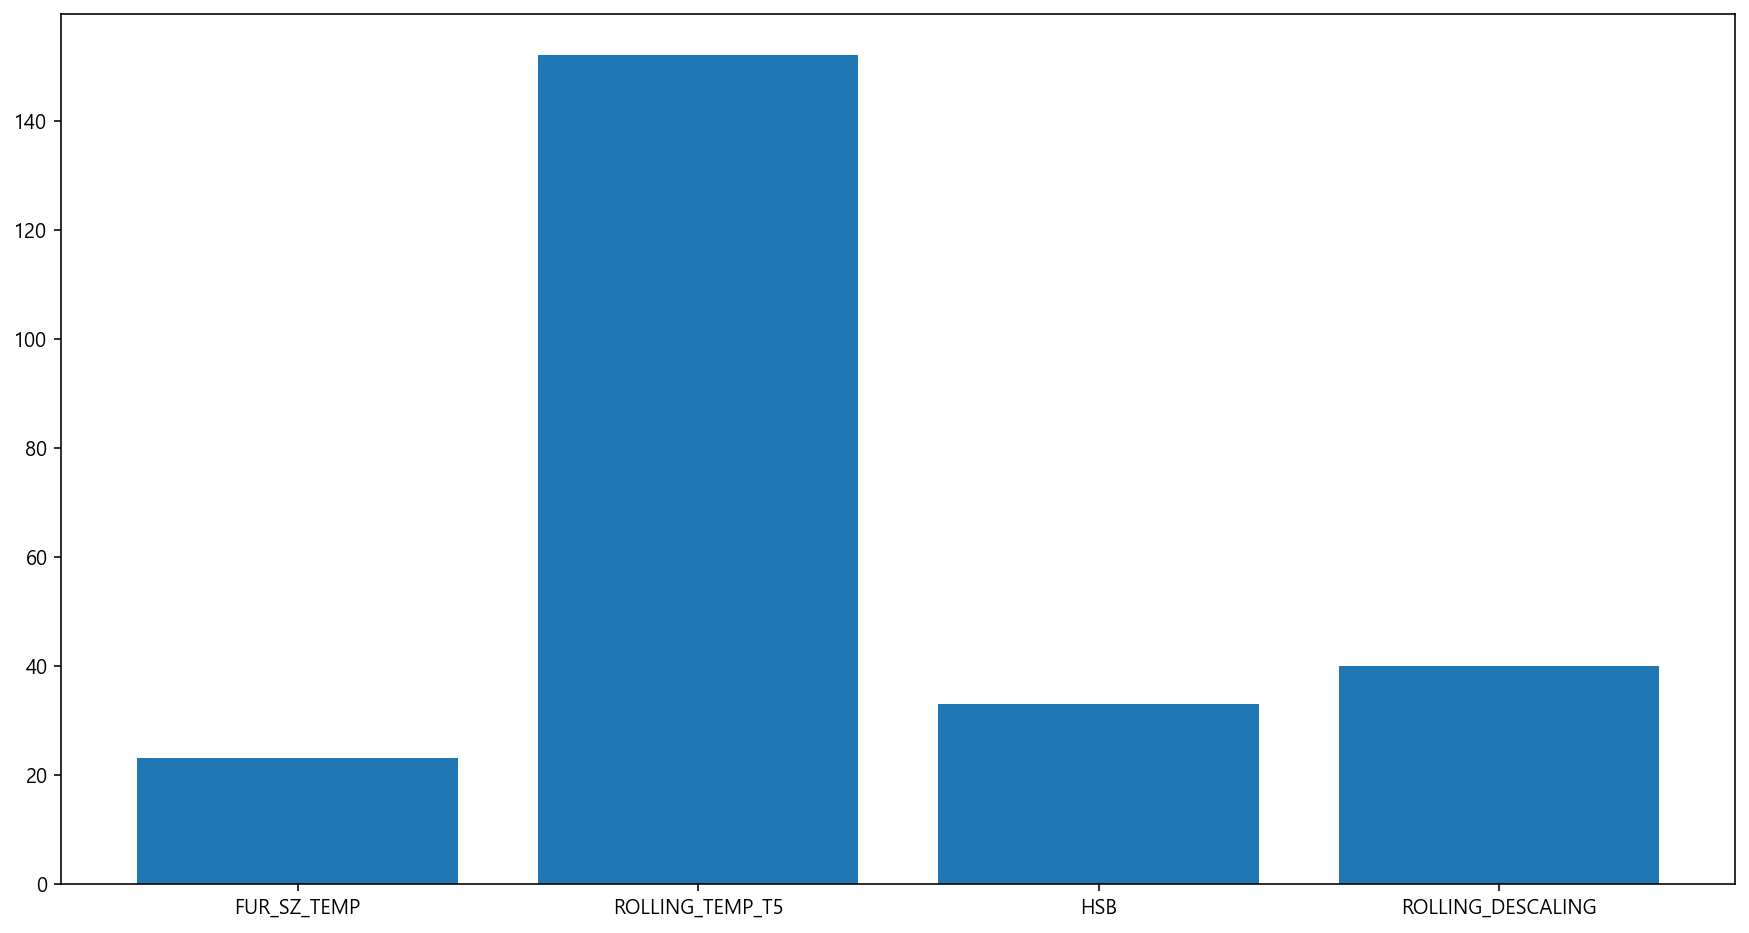

In [42]:
plt.bar( x = ('FUR_SZ_TEMP', 'ROLLING_TEMP_T5', 'HSB', 'ROLLING_DESCALING') ,height = (len(steel_data[steel_data['SZ1175']==0]),len(steel_data[steel_data['RT1000']==0]),len(steel_data[steel_data['HSB']==0]),len(steel_data[steel_data['RDnum']==0])) )

* 중요도 또한 4요소 모두 잘 반영됨을 볼 수 있다. 중요도 수치 차이는 각 수치별 양품 개수와 직결될것이라 생각했는데 완벽히 그러지는 않는다. train set이 어떻게 선정됬는지가 영향을 미쳤을듯

## DecisionTree (ROLLING_DESCALING 칼럼만 그 횟수를 홀짝으로 구분한 RDnum 칼럼으로 교체)

In [43]:
from sklearn.model_selection import train_test_split

X = steel_data[['FUR_NO', 'FUR_NO_ROW', 'FUR_HZ_TEMP','FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP', 'WORK_GR','ROLLING_TEMP_T5','HSB','RDnum']]
Y = steel_data['SCALE'] # 목표 = 양품Scale

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)

In [44]:
from sklearn.tree import DecisionTreeClassifier
#for i in range(1,6):
i=4
dtc = DecisionTreeClassifier(max_depth =i)
dtc.fit(X_train,Y_train)
pred_rf = dtc.predict(X_test)

dtc_train_score = dtc.score(X_train, Y_train)
dtc_test_score = dtc.score(X_test, Y_test)
print(f'max_depth = {i},  dtc_train_score : {round(dtc_train_score,3)}, dtc_test_score : {round(dtc_test_score,3)}, delta : {round(dtc_train_score-dtc_test_score,3)}')

max_depth = 4,  dtc_train_score : 1.0, dtc_test_score : 1.0, delta : 0.0


In [45]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, pred_rf)
print(conf_matrix)

from sklearn.metrics import classification_report
class_report = classification_report(Y_test, pred_rf)
print(class_report)

[[ 42   0]
 [  0 101]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       101

    accuracy                           1.00       143
   macro avg       1.00      1.00      1.00       143
weighted avg       1.00      1.00      1.00       143



C:\Users\BECK\AppData\Local\Temp\ipykernel_25700\2715364660.py:4: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



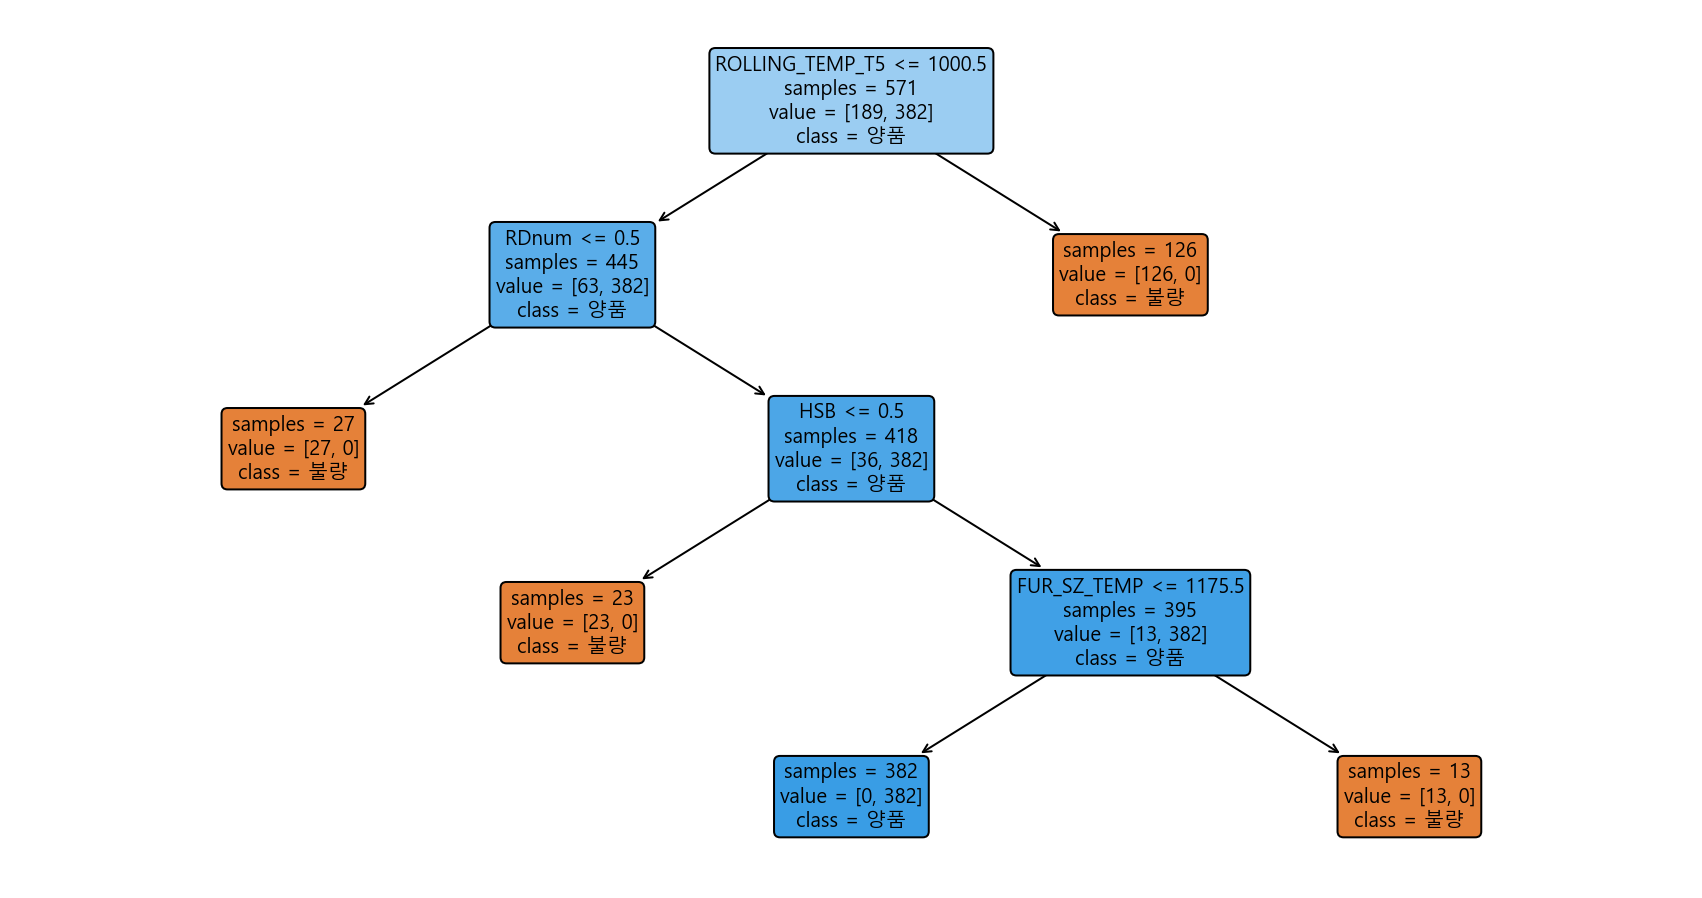

In [46]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")
plt.rcParams['figure.figsize'] = [15,8]

plot_tree(dtc, class_names=["불량", "양품"],
          feature_names=dtc.feature_names_in_,
         impurity=False, filled=True, rounded=True, fontsize=10)

plt.show()

* 모델이 잘못 판단한 ROLLING_DESCALING만 on/off 스위치형 RDnum 칼럼으로 교체하였더니 train,test score모두 1.0이 나왔다. 
* 결정모델을 시각화 해보니 데이터 프로세싱 과정에서 확인한 4개 스위치_공정 모두 완벽히 DecisionTree모델이 산출하였음을 볼수 있다. 즉 train,test score모두 1.0 인 것은 overfitting이 아니고, 양품률이 4개 요소에만 좌우되고 모델이 그 4개요소를 완벽히 파악했기 떄문에 나온 결과이다. 

## Random_Forest

In [47]:
#다시 원본데이터 이용
from sklearn.model_selection import train_test_split

X = steel_data[['FUR_NO', 'FUR_NO_ROW', 'FUR_HZ_TEMP','FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP', 'WORK_GR','ROLLING_TEMP_T5','HSB','ROLLING_DESCALING']]
Y = steel_data['SCALE'] # 목표 = 양품Scale

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)

In [48]:
from sklearn.ensemble import RandomForestClassifier
""" for i in range(1,6):
    for j in range(1,10): """
i=3
j=2
rf = RandomForestClassifier(max_depth =i, n_estimators =50*j)
rf.fit(X_train, Y_train.ravel())
pred_rf = rf.predict(X_test)

rf_train_score = rf.score(X_train, Y_train.ravel())
rf_test_score = rf.score(X_test, Y_test.ravel())
print(f'max_depth = {i}, n_estimators : {25*j}, rf_train_score : {round(rf_train_score,3)}, rf_test_score : {round(rf_test_score,3)}, delta : {round(rf_train_score-rf_test_score,3)}')

max_depth = 3, n_estimators : 50, rf_train_score : 0.949, rf_test_score : 0.965, delta : -0.016


* for문을 이용해 스코어를 확인해보니 max_depth = 3, n_estimators : 50 가 제일 가성비 좋아보임

In [49]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, pred_rf)
print(conf_matrix)

from sklearn.metrics import classification_report
class_report = classification_report(Y_test, pred_rf)
print(class_report)

[[ 37   5]
 [  0 101]]
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        42
           1       0.95      1.00      0.98       101

    accuracy                           0.97       143
   macro avg       0.98      0.94      0.96       143
weighted avg       0.97      0.97      0.96       143



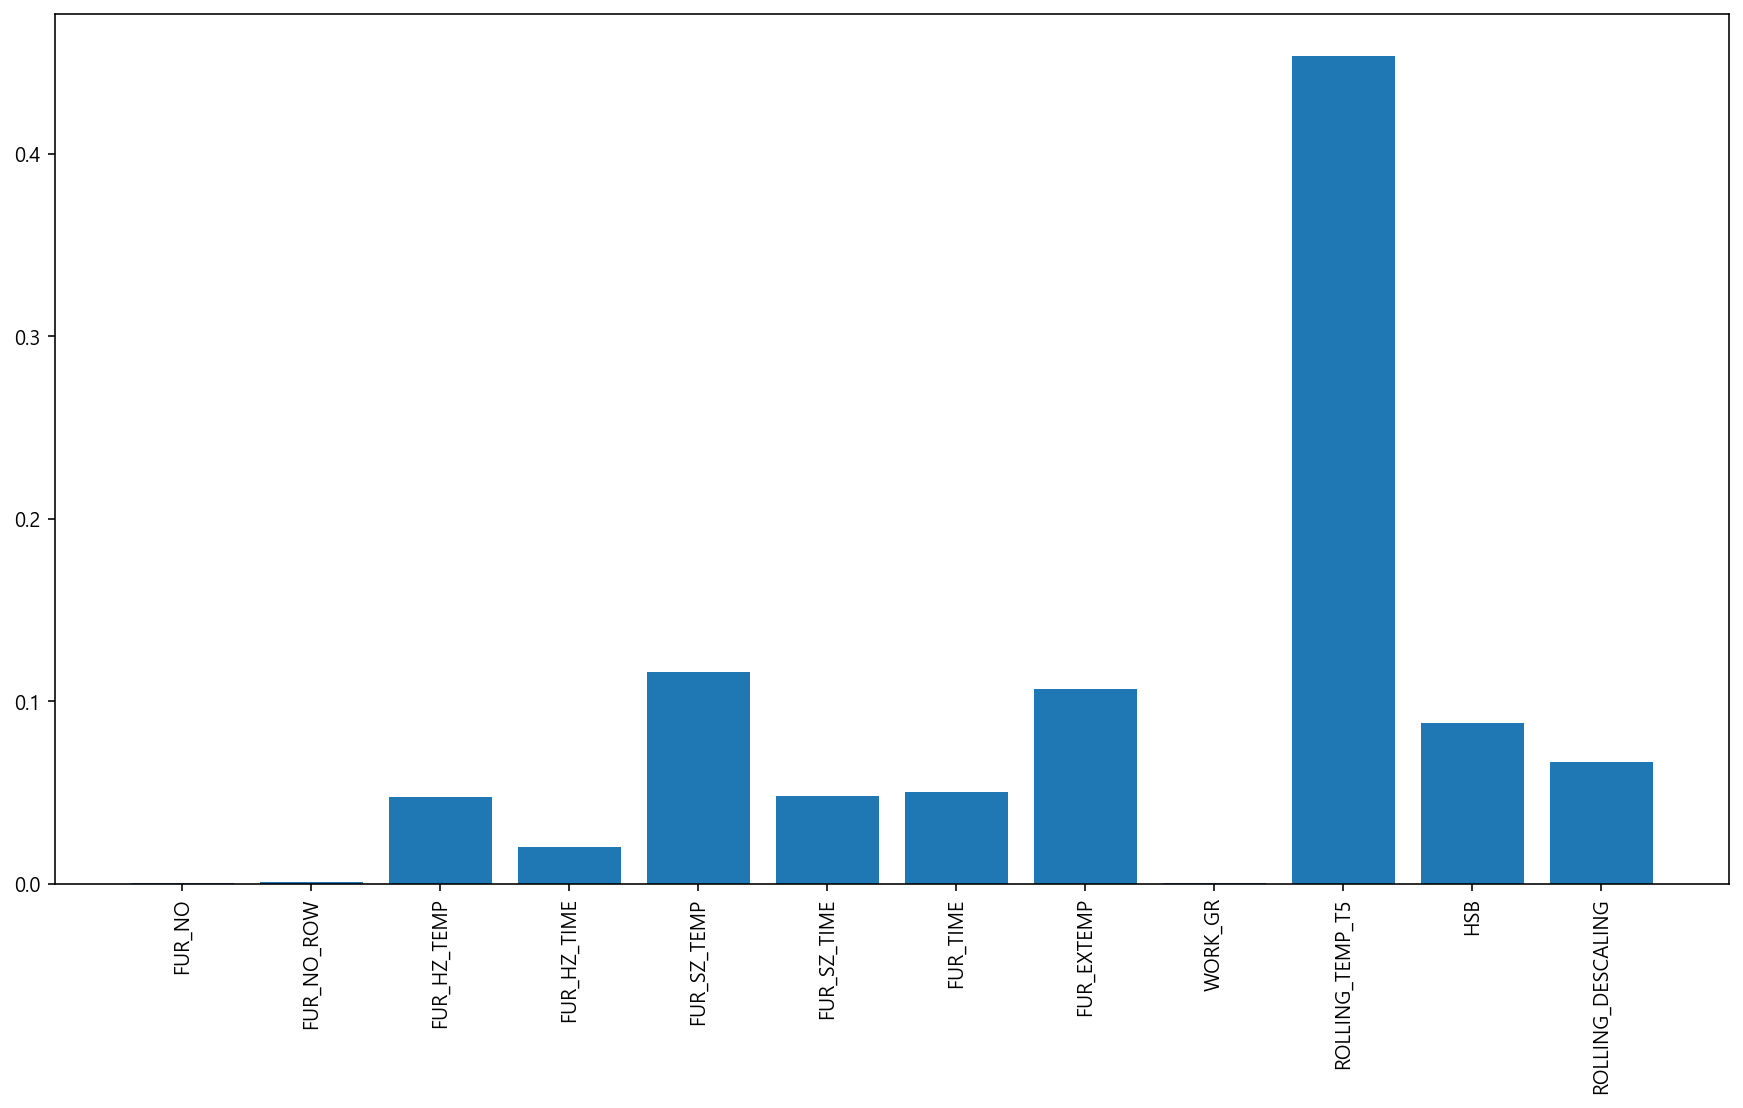

In [50]:
importance = rf.feature_importances_
importance
plt.figure()
plt.bar(range(len(importance)),importance)
plt.xticks(range(len(importance)),X.columns,rotation=90)
plt.show()

## Gradient Boosting

In [51]:
from sklearn.ensemble import GradientBoostingClassifier


""" for i in range(1,5):
    for j in range(1,11): """
i = 4  #4
j = 4  #4
gbrt = GradientBoostingClassifier(max_depth = i, learning_rate = 0.01*j)
gbrt.fit(X_train,Y_train)
pred_rf = gbrt.predict(X_test)

gbrt_train_score = gbrt.score(X_train, Y_train)
gbrt_test_score = gbrt.score(X_test, Y_test)
print(f'max_depth = {i}, learning_rate={0.01*j}, gbrt_train_score : {round(gbrt_train_score,3)}, gbrt_test_score : {round(gbrt_test_score,3)}, delta : {round(gbrt_train_score-gbrt_test_score,3)}')

max_depth = 4, learning_rate=0.04, gbrt_train_score : 1.0, gbrt_test_score : 1.0, delta : 0.0


In [52]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, pred_rf)
print(conf_matrix)

from sklearn.metrics import classification_report
class_report = classification_report(Y_test, pred_rf)
print(class_report)

[[ 42   0]
 [  0 101]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       101

    accuracy                           1.00       143
   macro avg       1.00      1.00      1.00       143
weighted avg       1.00      1.00      1.00       143



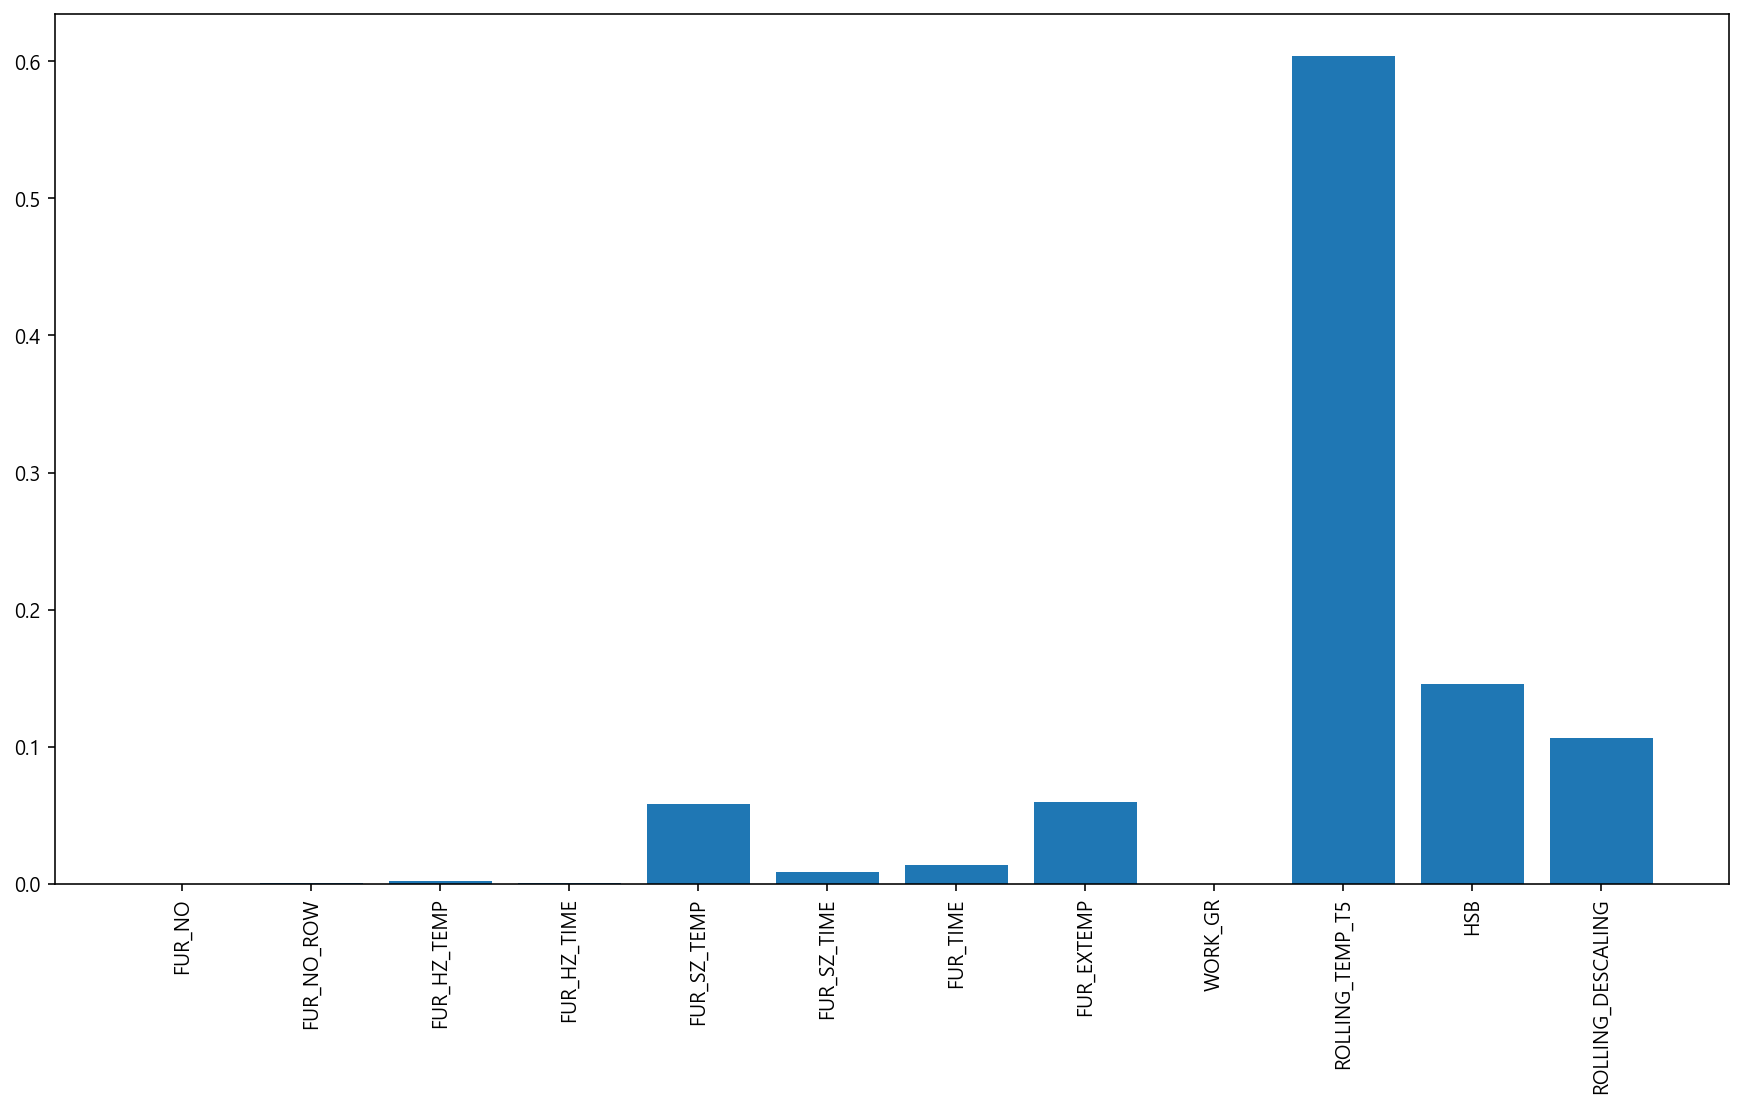

In [53]:
importance = gbrt.feature_importances_
importance
plt.figure()
plt.bar(range(len(importance)),importance)
plt.xticks(range(len(importance)),X.columns,rotation=90)
plt.show()

## 총평

* 결과적으로 수율에 관여하는 요소는 FUR_SZ_TEMP , HSB 적용 여부, ROLLING_DESCALING 작업 횟수, ROLLING_TEMP_T5(롤링 온도) 넷 뿐이고,  이 네 공정의 정상 공정률은 FUR_NO , WORK_GR에 종속되는 경향을 보인다.
